In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.fv1d import solve_fv
from src.dataset_gen import make_dataset_h5
from pathlib import Path
import os
import h5py
import tensorflow as tf

# Repro
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
H5_PATH = "Data/data_burgers_ref.h5"
CKPT_DIR = "models"
os.makedirs("Data", exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

# Coarse settings (for Phase 4–5)
N_COARSE = 100
CFL = 0.25  

# Phase lengths
PH3_EPOCHS = 20
PH3_BATCH = 4096

PH4_STEPS = 5000
PH5_STEPS = 5000
PRINT_EVERY = 200

# Loss weights (keep Phase-3 losses always on)
W_CONS = 1e-2
W_GRAD = 1e-3
W_DISS = 1e-2

W_RES  = 0.05   # Phase 4
W_ROLL = 1.0   # Phase 5

# Rollout horizon for Phase 5
K_ROLL = 8

# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)


In [2]:
FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, dpi=250):
    fig.savefig(FIG_DIR / f"{name}.png", dpi=dpi, bbox_inches="tight")
    fig.savefig(FIG_DIR / f"{name}.pdf", bbox_inches="tight")

def _safe(arr):
    arr = np.asarray(arr, dtype=float)
    return arr[np.isfinite(arr)]

def _percentile_summary(x):
    x = _safe(x)
    if x.size == 0:
        return None
    return dict(
        n=int(x.size),
        median=float(np.median(x)),
        p10=float(np.percentile(x, 10)),
        p90=float(np.percentile(x, 90)),
        mean=float(np.mean(x)),
        win_rate=float(np.mean(x < 1.0)),
    )

def _pick_rows_by_ratio(df, ratio_col="err_ratio_final"):
    """Return indices for median and worst case by ratio."""
    ratios = np.asarray([r[ratio_col] for r in df], dtype=float)
    ratios = np.where(np.isfinite(ratios), ratios, np.inf)
    order = np.argsort(ratios)
    idx_med = int(order[len(order)//2])
    idx_worst = int(order[-1])
    return idx_med, idx_worst

def _heatmap_abs_error(traj, ref):
    # traj/ref: (K, N)
    return np.abs(traj - ref)


In [3]:
def ic_sine(x):
    return np.sin(2*np.pi*x)

def ic_riemann(x):
    return np.where(x < 0.0, 1.0, -1.0)

def ic_gaussian(x):
    return np.exp(-x*x/2)


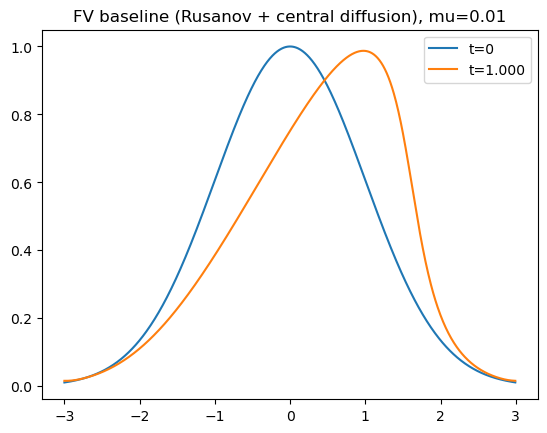

In [4]:
N = 1000
a, b = -3.0, 3.0
x = np.linspace(a, b, N, endpoint=False)
T = 1
mu = 1e-2
bc = "periodic"

u0 = ic_gaussian(x) 
times, snaps = solve_fv(u0, x, T=T, mu=mu, bc=bc, cfl=0.4, save_every=20)

plt.figure()
plt.plot(x, u0, label="t=0")
plt.plot(x, snaps[-1], label=f"t={times[-1]:.3f}")
plt.legend()
plt.title(f"FV baseline (Rusanov + central diffusion), mu={mu}")
plt.show()


In [5]:
make_dataset_h5(
    out_path="Data/data_burgers_ref.h5",
    num_cases=256,
    N_fine=1000,
    T=0.5,
    mu_min=1e-3,
    mu_max=1e-1,
    save_stride=20,
    seed=0,
)


Generating cases:   1%|          | 3/256 [00:05<08:02,  1.91s/it]


KeyboardInterrupt: 

In [6]:
def inspect_dataset_layout_2x2_plus_heatmap(h5_path, case_idx=0, max_scatter=6000):
    h5_path = Path(h5_path)
    if not h5_path.exists():
        raise FileNotFoundError(f"Dataset not found: {h5_path}")

    with h5py.File(h5_path, "r") as f:
        cases = sorted(f["cases"].keys())
        if len(cases) == 0:
            raise ValueError("No cases found under group 'cases'.")

        case_idx = int(np.clip(case_idx, 0, len(cases) - 1))
        g = f["cases"][cases[case_idx]]

        x = g["x"][:]
        times = g["times"][:]
        U = g["U"][:]  # shape [Nt, N]
        mu = float(g.attrs["mu"])

        uL = g["uL"][:] if "uL" in g else None
        uR = g["uR"][:] if "uR" in g else None

    dx = float(x[1] - x[0])
    L = float(x.max() - x.min())

    # ----- Figure layout: 3 rows; (2,2,1 spanning) -----
    fig = plt.figure(figsize=(15, 11))

    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2])
    ax_heat = fig.add_subplot(gs[2, 1:3])  # middle half
    ax_snap  = fig.add_subplot(gs[0, 0])
    ax_mass  = fig.add_subplot(gs[0, 1])
    ax_scatt = fig.add_subplot(gs[1, 0])
    ax_jump  = fig.add_subplot(gs[1, 1])
    
    # ----- Row 1, Col 1: snapshots -----
    snap_ids = np.linspace(0, U.shape[0] - 1, 5, dtype=int)
    for k in snap_ids:
        ax_snap.plot(x, U[k], label=f"t={times[k]:.3f}")
    ax_snap.set_title("Solution snapshots")
    ax_snap.set_xlabel("x")
    ax_snap.set_ylabel("u")
    ax_snap.legend(fontsize=8)

    # ----- Row 1, Col 2: mass vs time -----
    mass = U.mean(axis=1) * L
    ax_mass.plot(times, mass, lw=2)
    ax_mass.set_title("Mass vs time")
    ax_mass.set_xlabel("t")
    ax_mass.set_ylabel(r"$\int u\,dx$ (approx)")

    # ----- Row 2, Col 1: (uL, uR) scatter -----
    if uL is not None and uR is not None and uL.size > 0:
        n = min(max_scatter, uL.size)
        idx = np.random.choice(uL.size, size=n, replace=False)
        ax_scatt.scatter(uL[idx], uR[idx], s=6, alpha=0.25)

        # diagonal reference line using current limits after scatter
        lo = min(ax_scatt.get_xlim()[0], ax_scatt.get_ylim()[0])
        hi = max(ax_scatt.get_xlim()[1], ax_scatt.get_ylim()[1])
        ax_scatt.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax_scatt.set_title("(uL, uR) scatter")
        ax_scatt.set_xlabel("uL")
        ax_scatt.set_ylabel("uR")
    else:
        ax_scatt.text(0.5, 0.5, "No interface data (uL/uR) found",
                      ha="center", va="center")
        ax_scatt.set_axis_off()

    # ----- Row 2, Col 2: jump histogram -----
    if uL is not None and uR is not None and uL.size > 0:
        jump = uR - uL
        ax_jump.hist(jump, bins=120)
        ax_jump.set_title("Jump distribution (uR - uL)")
        ax_jump.set_xlabel("uR - uL")
        ax_jump.set_ylabel("count")
    else:
        ax_jump.text(0.5, 0.5, "No interface data (uL/uR) found",
                     ha="center", va="center")
        ax_jump.set_axis_off()

    # ----- Row 3: heatmap spanning full width -----
    im = ax_heat.imshow(
        U,
        aspect="auto",
        origin="lower",
        extent=[x.min(), x.max(), times.min(), times.max()],
    )
    ax_heat.set_title("Space–time heatmap")
    ax_heat.set_xlabel("x")
    ax_heat.set_ylabel("t")
    fig.colorbar(im, ax=ax_heat, fraction=0.025, pad=0.02, label="u")

    fig.suptitle(
        f"Viscous Burgers reference data inspection | case={case_idx} | "
        f"N={x.size} | Nt={U.shape[0]} | dx={dx:.3e} | mu={mu:.2e}",
        fontsize=14
    )

    fig.tight_layout()
    plt.show()



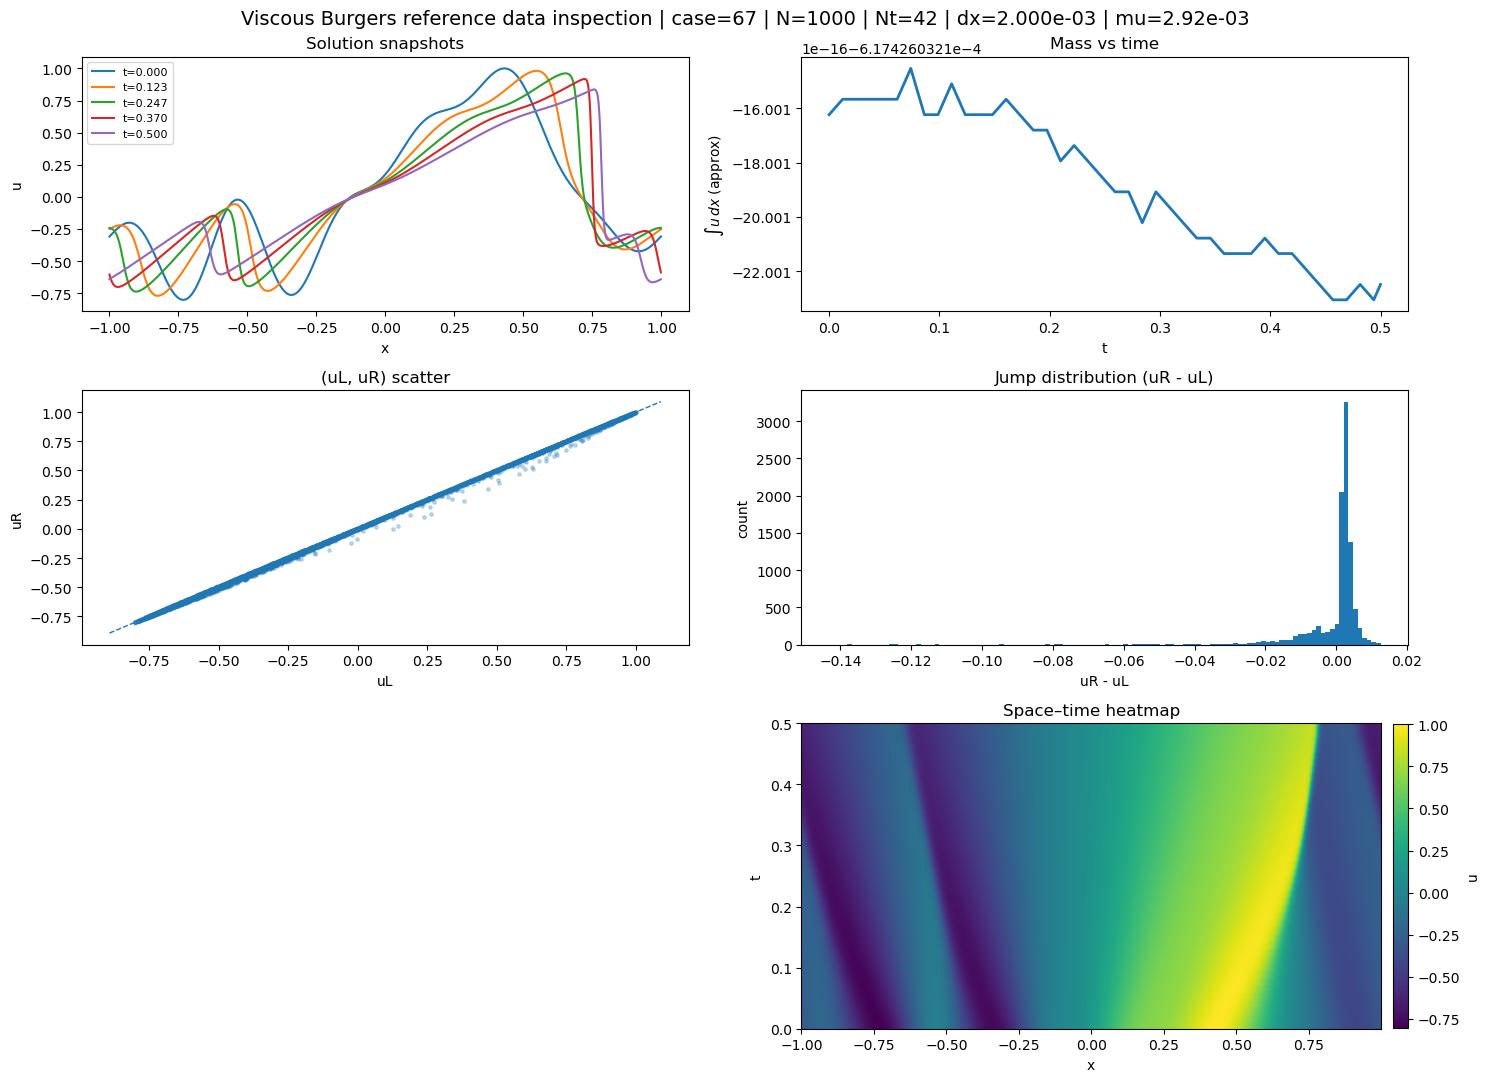

In [10]:
inspect_dataset_layout_2x2_plus_heatmap("Data/data_burgers_ref.h5", case_idx=67)

In [37]:
# ============================================================
# 1) Model: Neural flux for Burgers
#    F = 0.5*(f(uL)+f(uR)) + (uR-uL)*phi_theta(uL,uR,logmu)
# ============================================================
class NeuralFlux1(tf.keras.Model):
    def __init__(self, hidden_sizes=(64, 64), activation="tanh"):
        super().__init__()
        layers = []
        for h in hidden_sizes:
            layers.append(tf.keras.layers.Dense(h, activation=activation))
        layers.append(tf.keras.layers.Dense(1, activation=None))
        self.net = tf.keras.Sequential(layers)

    @staticmethod
    def physical_flux(u):
        return 0.5 * tf.square(u)

    def call(self, X):
        """
        X: [batch, 3] = (uL, uR, log(mu))
        returns: [batch, 1] flux value
        """
        uL = X[:, 0:1]
        uR = X[:, 1:2]
        logmu = X[:, 2:3]
        inp = tf.concat([uL, uR, logmu], axis=1)
        phi = self.net(inp)  # [batch,1]
        return 0.5*(self.physical_flux(uL) + self.physical_flux(uR)) + (uR - uL) * phi

model = NeuralFlux()
# build once
_ = model(tf.zeros([2,3], dtype=tf.float32))


In [12]:
# ============================================================
# 2) Utilities: load cases, downsample, and prepare training data
# ============================================================
def block_average_1d(u_fine: np.ndarray, N_coarse: int) -> np.ndarray:
    N_fine = u_fine.shape[0]
    assert N_fine % N_coarse == 0
    r = N_fine // N_coarse
    return u_fine.reshape(N_coarse, r).mean(axis=1)

def load_cases_from_h5(h5_path: str):
    cases = []
    with h5py.File(h5_path, "r") as f:
        cg = f["cases"]
        for name in cg.keys():
            g = cg[name]
            x = g["x"][:]
            times = g["times"][:]
            U = g["U"][:]          #[Nt, Nfine]
            mu = float(g.attrs["mu"])

            # interface samples (fine-grid adjacent pairs, stored for Phase 3)
            uL = g["uL"][:]
            uR = g["uR"][:]
            mu_vec = g["mu_vec"][:]

            cases.append(dict(name=name, x=x, times=times, U=U, mu=mu, uL=uL, uR=uR, mu_vec=mu_vec))
    return cases

cases = load_cases_from_h5(H5_PATH)
print(f"Loaded {len(cases)} cases from {H5_PATH}")
print("Example:", cases[0]["name"], "U shape:", cases[0]["U"].shape, "mu:", cases[0]["mu"])


Loaded 256 cases from Data/data_burgers_ref.h5
Example: case_00000 U shape: (262, 1000) mu: 0.01878985266149949


In [13]:
# ============================================================
# 3) Phase 3 data: interface-only dataset
# ============================================================
def make_phase3_dataset(cases, batch_size=4096, shuffle_buf=200000):
    # concatenate interface samples across cases
    UL = np.concatenate([c["uL"] for c in cases]).astype(np.float32)
    UR = np.concatenate([c["uR"] for c in cases]).astype(np.float32)
    MU = np.concatenate([c["mu_vec"] for c in cases]).astype(np.float32)
    LOGMU = np.log(MU + 1e-30).astype(np.float32)

    X = np.stack([UL, UR, LOGMU], axis=1)  # [N,3]
    ds = tf.data.Dataset.from_tensor_slices(X)
    ds = ds.shuffle(min(shuffle_buf, X.shape[0]), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

ds_phase3 = make_phase3_dataset(cases, batch_size=PH3_BATCH)


In [27]:
# ============================================================
# 4) TF FV building blocks for Phase 4–5 (differentiable)
#    - periodic BCs
#    - diffusion via central Laplacian
# ============================================================
@tf.function
def laplacian_periodic_tf(u, dx):
    return (tf.roll(u, shift=-1, axis=0) - 2.0*u + tf.roll(u, shift=1, axis=0)) / (dx*dx)

@tf.function
def flux_divergence_tf(u, dx, mu, model):
    """
    Convection term: -(F_{i+1/2}-F_{i-1/2})/dx, periodic.
    u: [N]
    """
    uL = u
    uR = tf.roll(u, shift=-1, axis=0)
    logmu = tf.fill([tf.shape(u)[0]], tf.math.log(mu))
    X = tf.stack([uL, uR, logmu], axis=1)   # [N,3]
    F_iphalf = tf.squeeze(model(X), axis=1) # [N]
    F_imhalf = tf.roll(F_iphalf, shift=1, axis=0)
    return -(F_iphalf - F_imhalf) / dx

@tf.function
def rhs_fv_tf(u, dx, mu, model):
    return flux_divergence_tf(u, dx, mu, model) + mu * laplacian_periodic_tf(u, dx)


@tf.function
def stable_dt_cap_tf(u, dx, mu, cfl_adv=0.45, cfl_diff=0.45, dt_max=1e9):
    umax = tf.reduce_max(tf.abs(u)) + 1e-12
    dt_adv  = cfl_adv  * dx / umax
    dt_diff = cfl_diff * dx*dx / (mu + 1e-12)
    return tf.minimum(dt_max, tf.minimum(dt_adv, dt_diff))

def ssp_rk3_step_tf_substepped(u, dt, dx, mu, model, cfl_adv=0.45, cfl_diff=0.45):
    """
    Substep RK3 so that each micro-step respects advective+diffusive stability caps.
    u: tf.Tensor [N]
    dt: float
    """
    t = 0.0
    u_cur = u
    dt_total = float(dt)

    while t < dt_total:
        # choose stable micro-step based on current u
        dt_loc = float(stable_dt_cap_tf(u_cur, dx, mu, cfl_adv, cfl_diff, dt_max=dt_total).numpy())
        h = min(dt_loc, dt_total - t)
        u_cur = ssp_rk3_step_tf(u_cur, h, dx, mu, model)
        if not np.all(np.isfinite(u_cur.numpy())):
            break
        t += h

    return u_cur

@tf.function
def ssp_rk3_step_tf(u, dt, dx, mu, model):
    """
    One SSP-RK3 step for the finite-volume RHS:
        u_t = -(F_{i+1/2}-F_{i-1/2})/dx + mu * Laplacian(u)

    This is the Shu–Osher SSP RK3 scheme:
        u^(1) = u^n + dt * L(u^n)
        u^(2) = 3/4 u^n + 1/4 (u^(1) + dt * L(u^(1)))
        u^(n+1) = 1/3 u^n + 2/3 (u^(2) + dt * L(u^(2)))
    """

    # stage 1
    k1 = rhs_fv_tf(u, dx, mu, model)
    u1 = u + dt * k1

    # stage 2
    k2 = rhs_fv_tf(u1, dx, mu, model)
    u2 = 0.75 * u + 0.25 * (u1 + dt * k2)

    # stage 3
    k3 = rhs_fv_tf(u2, dx, mu, model)
    un = (1.0/3.0) * u + (2.0/3.0) * (u2 + dt * k3)

    return un




def fv_rhs_rusanov_diffusion(u, dx, mu):
    """
    Finite-volume RHS for viscous Burgers in 1D with periodic BC:
        u_t = - (F_{i+1/2} - F_{i-1/2})/dx + mu * (u_{i+1} - 2u_i + u_{i-1})/dx^2

    Uses Rusanov numerical flux for the convective part and a standard 2nd-difference for diffusion.
    """
    u = np.asarray(u)

    # convective flux divergence (FV)
    uL = u
    uR = np.roll(u, -1)
    Fp = rusanov_flux(uL, uR)      # F_{i+1/2}
    Fm = np.roll(Fp, 1)            # F_{i-1/2}
    divF = (Fp - Fm) / dx

    # diffusion (FD on cell averages; consistent with what you already did)
    lap = (np.roll(u, -1) - 2.0*u + np.roll(u, 1)) / (dx*dx)

    return -(divF) + mu * lap

def stable_dt_cap_np(u, dx, mu, cfl_adv=0.45, cfl_diff=0.45, dt_max=np.inf):
    umax = float(np.max(np.abs(u))) + 1e-12
    dt_adv  = cfl_adv  * dx / umax
    dt_diff = cfl_diff * dx*dx / (mu + 1e-12)
    return float(min(dt_max, dt_adv, dt_diff))

def ssp_rk3_step_rusanov(u, dt, dx, mu):
    u0 = np.asarray(u, dtype=float)
    k1 = fv_rhs_rusanov_diffusion(u0, dx, mu)
    u1 = u0 + dt*k1
    k2 = fv_rhs_rusanov_diffusion(u1, dx, mu)
    u2 = 0.75*u0 + 0.25*(u1 + dt*k2)
    k3 = fv_rhs_rusanov_diffusion(u2, dx, mu)
    un = (1/3)*u0 + (2/3)*(u2 + dt*k3)
    return un

def ssp_rk3_step_rusanov_substepped(u, dt, dx, mu, cfl_adv=0.45, cfl_diff=0.45):
    t = 0.0
    u_cur = u.copy()
    while t < dt:
        dt_loc = stable_dt_cap_np(u_cur, dx, mu, cfl_adv, cfl_diff, dt_max=dt)
        h = min(dt_loc, dt - t)
        u_cur = ssp_rk3_step_rusanov(u_cur, h, dx, mu)
        if not np.all(np.isfinite(u_cur)):
            break
        t += h
    return u_cur


In [28]:
# ============================================================
# 5) Regularizers (Phase 3 losses that remain active in Phase 4–5)
# ============================================================
@tf.function
def loss_consistency(model, X):
    # enforce F_theta(u,u) == f(u)
    u = X[:, 0:1]
    mu_log = X[:, 2:3]
    Xc = tf.concat([u, u, mu_log], axis=1)
    f_cons = model(Xc)
    f_phys = 0.5 * tf.square(u)
    return tf.reduce_mean(tf.square(f_cons - f_phys))

@tf.function
def loss_grad_smooth(model, X):
    # penalize gradients of flux wrt inputs (a proxy for smoothness/Lipschitz control)
    with tf.GradientTape() as tape:
        tape.watch(X)
        f_hat = model(X)
    J = tape.gradient(f_hat, X)  # [B,3]
    return tf.reduce_mean(tf.square(J))

@tf.function
def loss_dissipation_bias(model, X):
    # penalize positive dissipation: (uR-uL)*phi should be <= 0
    uL = X[:, 0:1]
    uR = X[:, 1:2]
    logmu = X[:, 2:3]
    # recover phi via: F - 0.5(fL+fR) = (uR-uL)*phi
    F = model(X)
    base = 0.5*(0.5*tf.square(uL) + 0.5*tf.square(uR))
    denom = (uR - uL)
    phi = (F - base) / (denom + 1e-12)
    diss = (uR - uL) * phi
    return tf.reduce_mean(tf.nn.relu(diss))  # penalize > 0


In [29]:
# ============================================================
# 6) Phase 3: interface-only training step
# ============================================================
@tf.function
def phase3_train_step(model, optimizer, X,
                      w_cons=W_CONS, w_grad=W_GRAD, w_diss=W_DISS):
    with tf.GradientTape() as tape:
        Lc = loss_consistency(model, X)
        Lg = loss_grad_smooth(model, X)
        Ld = loss_dissipation_bias(model, X)
        loss = w_cons*Lc + w_grad*Lg + w_diss*Ld
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, Lc, Lg, Ld


In [17]:
# ============================================================
# 7) Build coarse trajectories (used by Phase 4–5)
# ============================================================
def build_coarse_cases(cases, N_coarse):
    coarse = []
    for c in cases:
        Ufine = c["U"]  # [Nt, Nfine]
        xfine = c["x"]
        times = c["times"]
        mu = c["mu"]

        # coarse cell averages from fine truth
        Uc = np.stack(
            [block_average_1d(Ufine[n], N_coarse) for n in range(Ufine.shape[0])],
            axis=0
        ).astype(np.float32)  # [Nt, Ncoarse]

        # coarse grid
        a = float(xfine.min())
        b = float(xfine.max())
        xcoarse = np.linspace(a, b, N_coarse, endpoint=False).astype(np.float32)
        dx = float(xcoarse[1] - xcoarse[0])

        coarse.append(dict(
            name=c["name"],
            times=times.astype(np.float32),
            Uc=Uc,
            x=xcoarse,
            dx=dx,
            mu=float(mu),
        ))
    return coarse

coarse_cases = build_coarse_cases(cases, N_COARSE)
print("Built coarse cases:", len(coarse_cases), "coarse shape:", coarse_cases[0]["Uc"].shape)

Built coarse cases: 256 coarse shape: (262, 100)


In [18]:
# ============================================================
# 8) Phase 4: residual-on-reference (teacher-forced)
# ============================================================
P4_SUBSTEPS = 5  # start with 5; increase to 10 if needed

@tf.function
def residual_on_reference_loss(u_n, u_np1, dt, dx, mu, model):
    # teacher-forced: advance u_n using the NN-flux FV solver and match u_np1
    dt_fv = dt / tf.cast(P4_SUBSTEPS, tf.float32)

    u = u_n
    for _ in tf.range(P4_SUBSTEPS):
        u = ssp_rk3_step_tf(u, dt_fv, dx, mu, model)

    # Now compare evolved state to the reference next snapshot
    return tf.reduce_mean(tf.square(u - u_np1))


#@tf.function
#def residual_on_reference_loss(u_n, u_np1, dt, dx, mu, model):
#    du_dt = (u_np1 - u_n) / dt
#    flux_div = flux_divergence_tf(u_n, dx, mu, model)
#    lap = laplacian_periodic_tf(u_n, dx)
#   res = du_dt + flux_div - mu * lap
#    return tf.reduce_mean(tf.square(res))

def sample_phase4_pair(coarse_cases):
    c = coarse_cases[np.random.randint(len(coarse_cases))]
    U = c["Uc"]
    times = c["times"]
    # pick consecutive saved snapshots
    n = np.random.randint(0, U.shape[0] - 1)
    u_n = U[n]
    u_np1 = U[n+1]
    dt = float(times[n+1] - times[n])
    return (u_n, u_np1, dt, c["dx"], c["mu"], c["name"])

@tf.function
def phase4_train_step(u_n, u_np1, dt, dx, mu, model, optimizer,
                      w_res=W_RES, w_cons=W_CONS, w_grad=W_GRAD, w_diss=W_DISS):
    # build a lightweight X batch for regularizers using neighbor pairs from u_n
    uL = u_n
    uR = tf.roll(u_n, shift=-1, axis=0)
    logmu = tf.fill([tf.shape(u_n)[0]], tf.math.log(mu))
    X = tf.stack([uL, uR, logmu], axis=1)

    with tf.GradientTape() as tape:
        Lres = residual_on_reference_loss(u_n, u_np1, dt, dx, mu, model)
        Lc = loss_consistency(model, X)
        Lg = loss_grad_smooth(model, X)
        Ld = loss_dissipation_bias(model, X)
        loss = w_res*Lres + w_cons*Lc + w_grad*Lg + w_diss*Ld
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, Lres, Lc, Lg, Ld


In [19]:
# ============================================================
# 9) Phase 5: short rollout loss
# ============================================================
P5_SUBSTEPS = 10  # start with 10; increase if unstable

@tf.function
def rollout_loss(u0, U_ref_future, dt, dx, mu, model):
    u = u0
    loss = 0.0

    dt_fv = dt / tf.cast(P5_SUBSTEPS, tf.float32)
    K = tf.shape(U_ref_future)[0]

    for k in tf.range(K):
        # advance from snapshot k to snapshot k+1 using substeps
        for _ in tf.range(P5_SUBSTEPS):
            u = ssp_rk3_step_tf(u, dt_fv, dx, mu, model)

        loss += tf.reduce_mean(tf.square(u - U_ref_future[k]))

    return loss / tf.cast(K, tf.float32)


def sample_phase5_rollout(coarse_cases, K):
    c = coarse_cases[np.random.randint(len(coarse_cases))]
    U = c["Uc"]
    times = c["times"]
    # pick a start such that we have K future reference snapshots
    n0 = np.random.randint(0, U.shape[0] - (K+1))
    u0 = U[n0]
    U_future = U[n0+1:n0+1+K]  # [K,N]
    dt = float(times[n0+1] - times[n0])     # dt between saved snapshots
    return (u0, U_future, dt, c["dx"], c["mu"], c["name"], float(times[n0]))

@tf.function
def phase5_train_step(u0, U_future, dt, dx, mu, model, optimizer,
                      w_roll=W_ROLL, w_cons=W_CONS, w_grad=W_GRAD, w_diss=W_DISS):
    # regularizers on (uL,uR) from current u0
    uL = u0
    uR = tf.roll(u0, shift=-1, axis=0)
    logmu = tf.fill([tf.shape(u0)[0]], tf.math.log(mu))
    X = tf.stack([uL, uR, logmu], axis=1)

    with tf.GradientTape() as tape:
        Lroll = rollout_loss(u0, U_future, dt, dx, mu, model)
        Lc = loss_consistency(model, X)
        Lg = loss_grad_smooth(model, X)
        Ld = loss_dissipation_bias(model, X)
        loss = w_roll*Lroll + w_cons*Lc + w_grad*Lg + w_diss*Ld
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, Lroll, Lc, Lg, Ld


In [20]:
# ============================================================
# 10) Run Phase 3 -> save checkpoint
# ============================================================
print("=== Phase 3: interface-only training ===")
for epoch in range(PH3_EPOCHS):
    last = None
    for batch in ds_phase3:
        last = phase3_train_step(model, optimizer, tf.cast(batch, tf.float32))
    loss, Lc, Lg, Ld = last
    print(f"Epoch {epoch:02d} | loss={float(loss):.3e} cons={float(Lc):.3e} grad={float(Lg):.3e} diss={float(Ld):.3e}")

ph3_path = os.path.join(CKPT_DIR, "phase3.keras")
model.save(ph3_path)
print("Saved:", ph3_path)


=== Phase 3: interface-only training ===


2025-12-20 12:31:57.425172: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 00 | loss=3.531e-05 cons=0.000e+00 grad=3.530e-02 diss=1.849e-06


2025-12-20 12:32:01.673754: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 01 | loss=3.487e-05 cons=0.000e+00 grad=3.486e-02 diss=7.071e-07
Epoch 02 | loss=3.527e-05 cons=0.000e+00 grad=3.527e-02 diss=4.138e-07


2025-12-20 12:32:09.762442: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 03 | loss=3.292e-05 cons=0.000e+00 grad=3.292e-02 diss=3.537e-07
Epoch 04 | loss=3.456e-05 cons=0.000e+00 grad=3.455e-02 diss=5.500e-07
Epoch 05 | loss=3.359e-05 cons=0.000e+00 grad=3.355e-02 diss=4.292e-06
Epoch 06 | loss=3.435e-05 cons=0.000e+00 grad=3.435e-02 diss=2.850e-07


2025-12-20 12:32:25.359846: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 07 | loss=3.359e-05 cons=0.000e+00 grad=3.358e-02 diss=5.417e-07
Epoch 08 | loss=3.490e-05 cons=0.000e+00 grad=3.489e-02 diss=3.030e-07
Epoch 09 | loss=3.458e-05 cons=0.000e+00 grad=3.458e-02 diss=5.274e-08
Epoch 10 | loss=3.526e-05 cons=0.000e+00 grad=3.525e-02 diss=1.116e-06
Epoch 11 | loss=3.437e-05 cons=0.000e+00 grad=3.436e-02 diss=4.133e-07
Epoch 12 | loss=3.573e-05 cons=0.000e+00 grad=3.572e-02 diss=8.865e-07
Epoch 13 | loss=3.346e-05 cons=0.000e+00 grad=3.343e-02 diss=3.402e-06
Epoch 14 | loss=3.543e-05 cons=0.000e+00 grad=3.540e-02 diss=2.662e-06


2025-12-20 12:32:55.640969: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 | loss=3.457e-05 cons=0.000e+00 grad=3.457e-02 diss=2.004e-08
Epoch 16 | loss=3.450e-05 cons=0.000e+00 grad=3.449e-02 diss=1.026e-06
Epoch 17 | loss=3.436e-05 cons=0.000e+00 grad=3.430e-02 diss=5.845e-06
Epoch 18 | loss=3.574e-05 cons=0.000e+00 grad=3.574e-02 diss=1.240e-08
Epoch 19 | loss=3.368e-05 cons=0.000e+00 grad=3.368e-02 diss=1.070e-08
Saved: models/phase3.keras


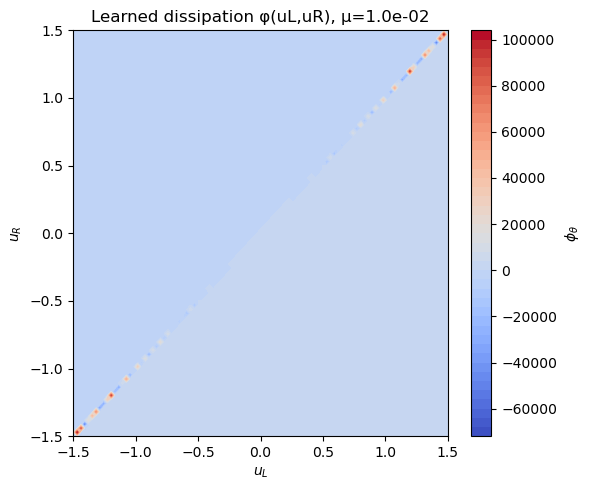

In [21]:
def plot_phi_surface(model, mu, umin=-1.5, umax=1.5, n=100):
    uL = np.linspace(umin, umax, n)
    uR = np.linspace(umin, umax, n)
    UL, UR = np.meshgrid(uL, uR)

    logmu = np.log(mu)
    X = np.stack([UL.ravel(), UR.ravel(),
                  logmu*np.ones_like(UL).ravel()], axis=1)
    X = tf.convert_to_tensor(X, tf.float32)

    F = model(X).numpy().reshape(n, n)
    base = 0.5*(0.5*UL**2 + 0.5*UR**2)
    phi = (F - base) / (UR - UL + 1e-12)

    plt.figure(figsize=(6,5))
    plt.contourf(UL, UR, phi, levels=50, cmap="coolwarm")
    plt.colorbar(label=r"$\phi_\theta$")
    plt.xlabel(r"$u_L$")
    plt.ylabel(r"$u_R$")
    plt.title(f"Learned dissipation φ(uL,uR), μ={mu:.1e}")
    plt.tight_layout()
    plt.show()

# example
plot_phi_surface(model, mu=1e-2)

In [22]:
def rusanov_flux(uL, uR):
    # Burgers flux
    fL = 0.5 * uL**2
    fR = 0.5 * uR**2
    a = np.maximum(np.abs(uL), np.abs(uR))
    return 0.5*(fL + fR) - 0.5*a*(uR - uL)

def plot_flux_grid(model, mu_list=(1e-3, 1e-2, 1e-1), umin=-2.0, umax=2.0, n=201, compare_rusanov=True):
    u = np.linspace(umin, umax, n)
    U_L, U_R = np.meshgrid(u, u, indexing="xy")   # shape (n, n)

    # Flatten for batch inference
    uL_flat = U_L.reshape(-1, 1).astype(np.float32)
    uR_flat = U_R.reshape(-1, 1).astype(np.float32)

    ncols = len(mu_list)
    fig, axes = plt.subplots(2 if compare_rusanov else 1, ncols, figsize=(5*ncols, 9 if compare_rusanov else 4.5))
    if ncols == 1:
        axes = np.array(axes).reshape((2,1)) if compare_rusanov else np.array(axes).reshape((1,1))

    for j, mu in enumerate(mu_list):
        log_mu = np.log(mu) * np.ones_like(uL_flat, dtype=np.float32)
        X = np.concatenate([uL_flat, uR_flat, log_mu], axis=1)  # (n^2, 3)

        f_nn = model(tf.convert_to_tensor(X)).numpy().reshape(n, n)

        ax0 = axes[0, j] if compare_rusanov else axes[0, j]
        im0 = ax0.imshow(
            f_nn,
            origin="lower",
            aspect="auto",
            extent=[umin, umax, umin, umax],
        )
        ax0.set_title(rf"$f_\theta(u_L,u_R;\mu={mu:.0e})$")
        ax0.set_xlabel(r"$u_L$")
        ax0.set_ylabel(r"$u_R$")
        fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

        if compare_rusanov:
            f_rus = rusanov_flux(U_L, U_R)
            diff = f_nn - f_rus
            ax1 = axes[1, j]
            im1 = ax1.imshow(
                diff,
                origin="lower",
                aspect="auto",
                extent=[umin, umax, umin, umax],
            )
            ax1.set_title(rf"$f_\theta - f_{{rus}}$ (mu={mu:.0e})")
            ax1.set_xlabel(r"$u_L$")
            ax1.set_ylabel(r"$u_R$")
            fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


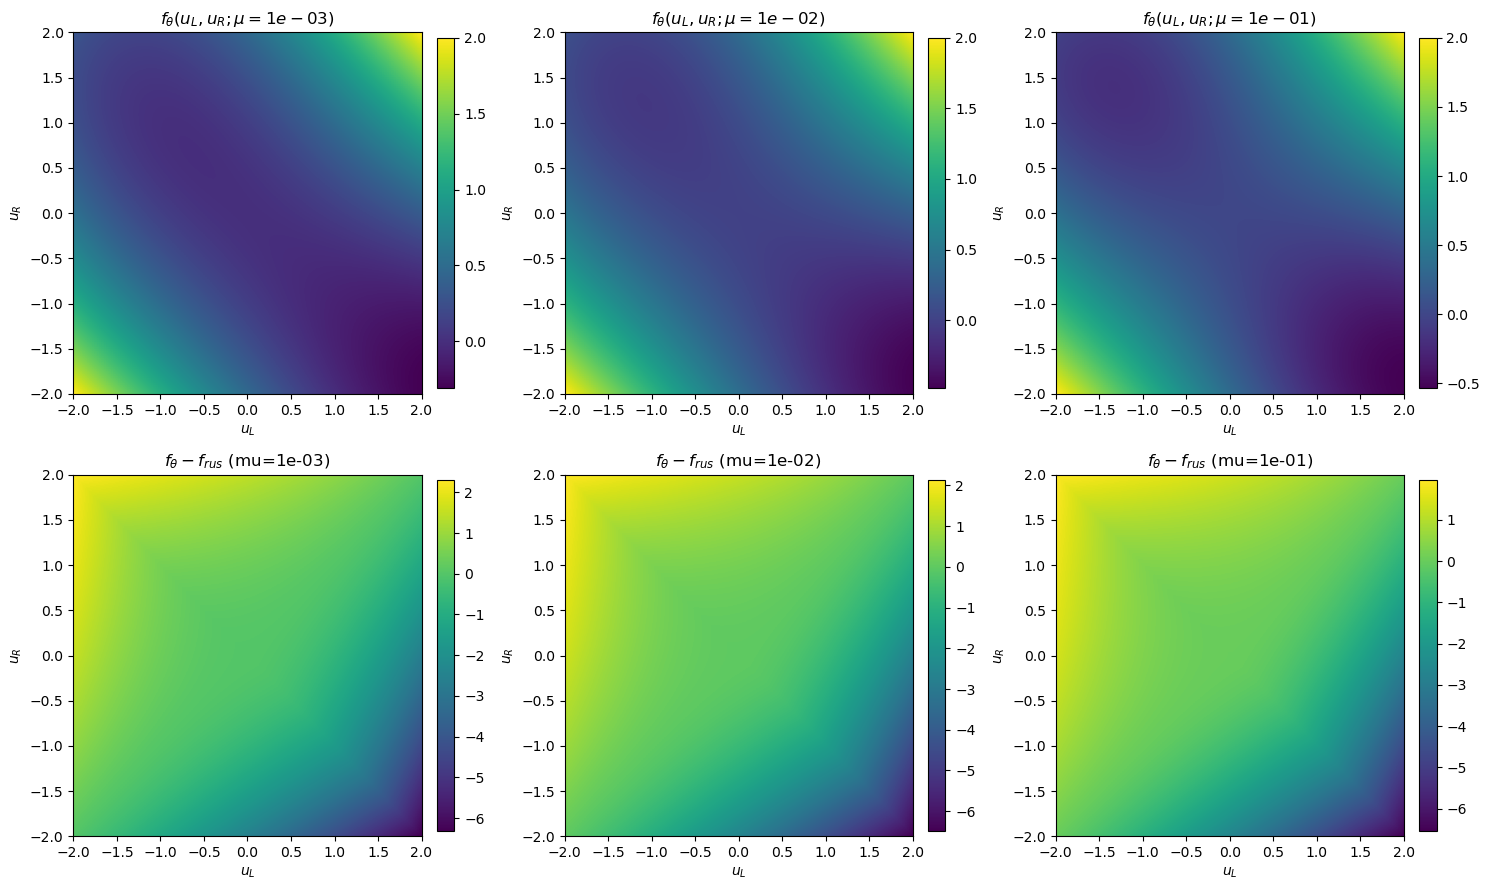

In [23]:
plot_flux_grid(model, mu_list=(1e-3, 1e-2, 1e-1))

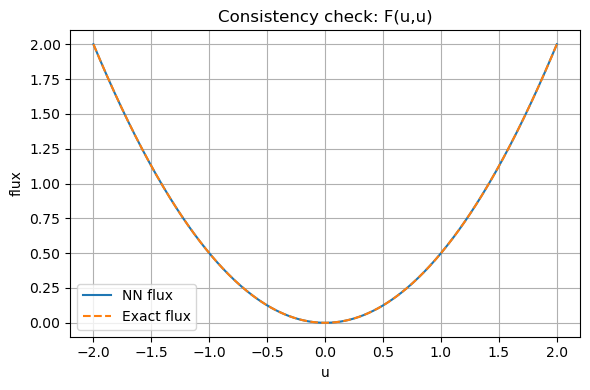

In [24]:
def plot_consistency(model):
    u = np.linspace(-2, 2, 400)
    X = np.stack([u, u, np.zeros_like(u)], axis=1)
    F = model(tf.convert_to_tensor(X, tf.float32)).numpy().squeeze()
    f_true = 0.5 * u**2

    plt.figure(figsize=(6,4))
    plt.plot(u, F, label="NN flux")
    plt.plot(u, f_true, "--", label="Exact flux")
    plt.xlabel("u")
    plt.ylabel("flux")
    plt.title("Consistency check: F(u,u)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_consistency(model)


In [25]:
def residual_norm(u_n, u_np1, dt, dx, mu, model):
    # NN
    u = tf.convert_to_tensor(u_n, tf.float32)
    du_dt = (u_np1 - u_n) / dt
    res_nn = du_dt + rhs_fv_tf(u, dx, mu, model).numpy()
    
    # Rusanov
    uL = u_n
    uR = np.roll(u_n, -1)
    Fp = rusanov_flux(uL, uR)
    Fm = np.roll(Fp, 1)
    res_ru = du_dt - (Fp - Fm)/dx + mu * (
        (np.roll(u_n,-1)-2*u_n+np.roll(u_n,1))/dx**2
    )

    return np.linalg.norm(res_nn), np.linalg.norm(res_ru)


=== Phase 4: residual-on-reference training ===
[P4] step=000200 case=case_00220 mu=7.72e-02 loss=1.563e-05 res=9.156e-14 cons=0.000e+00 grad=1.556e-02 diss=6.539e-06
[P4] step=000400 case=case_00035 mu=1.31e-03 loss=3.848e-05 res=9.707e-05 cons=0.000e+00 grad=2.886e-02 diss=4.767e-04
[P4] step=000600 case=case_00198 mu=7.37e-02 loss=1.499e-05 res=3.198e-12 cons=0.000e+00 grad=1.345e-02 diss=1.539e-04
[P4] step=000800 case=case_00030 mu=6.03e-02 loss=2.238e-05 res=5.181e-13 cons=0.000e+00 grad=2.221e-02 diss=1.728e-05


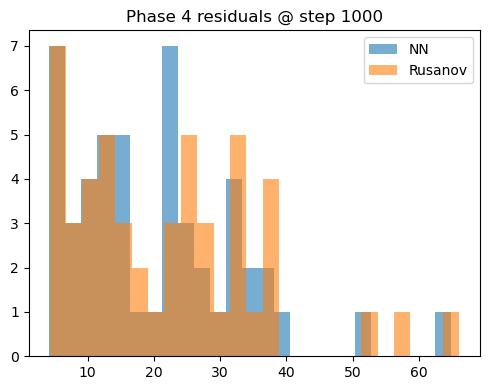

[P4] step=001000 case=case_00110 mu=3.75e-02 loss=3.386e-05 res=2.229e-08 cons=0.000e+00 grad=3.383e-02 diss=3.511e-06
[P4] step=001200 case=case_00203 mu=4.49e-02 loss=1.741e-05 res=1.125e-12 cons=0.000e+00 grad=1.740e-02 diss=1.425e-06
[P4] step=001400 case=case_00227 mu=2.67e-02 loss=4.139e-05 res=1.282e-10 cons=0.000e+00 grad=4.114e-02 diss=2.429e-05
[P4] step=001600 case=case_00234 mu=2.01e-03 loss=4.764e-05 res=5.558e-06 cons=0.000e+00 grad=4.673e-02 diss=6.389e-05
[P4] step=001800 case=case_00171 mu=1.49e-03 loss=3.900e-05 res=2.787e-04 cons=0.000e+00 grad=2.465e-02 diss=4.132e-05


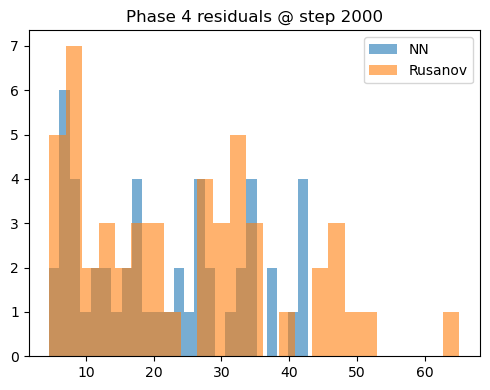

[P4] step=002000 case=case_00123 mu=1.54e-02 loss=3.511e-05 res=1.099e-04 cons=0.000e+00 grad=2.961e-02 diss=1.931e-07
[P4] step=002200 case=case_00047 mu=7.15e-02 loss=6.993e-06 res=1.242e-13 cons=0.000e+00 grad=6.870e-03 diss=1.233e-05
[P4] step=002400 case=case_00188 mu=6.72e-02 loss=1.235e-05 res=2.167e-12 cons=0.000e+00 grad=1.234e-02 diss=7.340e-07
[P4] step=002600 case=case_00144 mu=5.59e-02 loss=1.650e-05 res=5.635e-13 cons=0.000e+00 grad=1.634e-02 diss=1.579e-05
[P4] step=002800 case=case_00046 mu=1.63e-03 loss=5.590e-05 res=3.227e-04 cons=0.000e+00 grad=3.976e-02 diss=6.181e-07


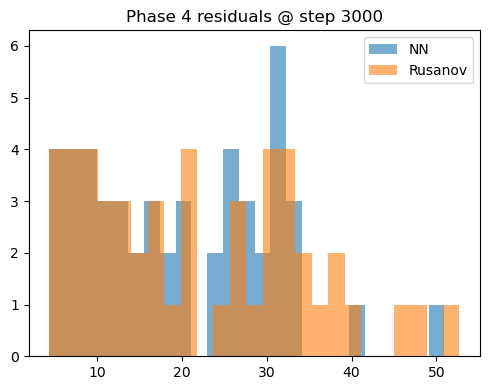

[P4] step=003000 case=case_00138 mu=4.00e-02 loss=4.340e-05 res=7.330e-05 cons=0.000e+00 grad=3.946e-02 diss=2.752e-05
[P4] step=003200 case=case_00235 mu=2.47e-02 loss=4.146e-05 res=2.718e-09 cons=0.000e+00 grad=4.137e-02 diss=8.814e-06
[P4] step=003400 case=case_00203 mu=4.49e-02 loss=2.702e-05 res=1.672e-11 cons=0.000e+00 grad=2.679e-02 diss=2.308e-05
[P4] step=003600 case=case_00122 mu=2.19e-02 loss=2.410e-05 res=1.167e-09 cons=0.000e+00 grad=2.410e-02 diss=1.371e-07
[P4] step=003800 case=case_00205 mu=9.86e-02 loss=2.654e-05 res=1.157e-12 cons=0.000e+00 grad=2.576e-02 diss=7.775e-05


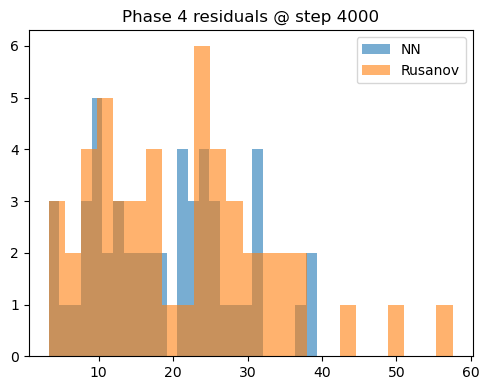

[P4] step=004000 case=case_00064 mu=1.20e-02 loss=4.405e-05 res=9.995e-05 cons=0.000e+00 grad=3.856e-02 diss=4.992e-05
[P4] step=004200 case=case_00019 mu=2.00e-02 loss=1.079e-05 res=4.670e-11 cons=0.000e+00 grad=1.072e-02 diss=7.184e-06
[P4] step=004400 case=case_00039 mu=1.27e-03 loss=3.421e-05 res=5.990e-05 cons=0.000e+00 grad=3.017e-02 diss=1.041e-04
[P4] step=004600 case=case_00227 mu=2.67e-02 loss=3.959e-05 res=1.814e-10 cons=0.000e+00 grad=3.902e-02 diss=5.763e-05
[P4] step=004800 case=case_00182 mu=2.56e-02 loss=1.150e-05 res=1.737e-11 cons=0.000e+00 grad=1.134e-02 diss=1.609e-05


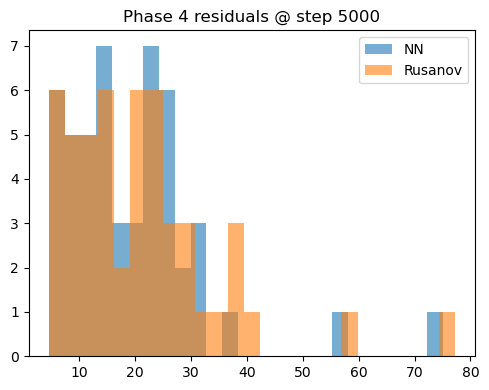

[P4] step=005000 case=case_00244 mu=1.00e-03 loss=3.799e-05 res=4.432e-09 cons=0.000e+00 grad=3.781e-02 diss=1.786e-05
Saved: models/phase4.keras


In [30]:
# ============================================================
# 11) Run Phase 4 -> save checkpoint
# ============================================================
print("\n=== Phase 4: residual-on-reference training ===")
for step in range(1, PH4_STEPS + 1):
    u_n, u_np1, dt, dx, mu, name = sample_phase4_pair(coarse_cases)
    out = phase4_train_step(
        tf.convert_to_tensor(u_n), tf.convert_to_tensor(u_np1),
        tf.constant(dt, tf.float32), tf.constant(dx, tf.float32), tf.constant(mu, tf.float32),
        model, optimizer
    )
    if step % 1000 == 0:
        res_nn, res_ru = [], []
        for _ in range(50):   # small probe batch
            u_n, u_np1, dt, dx, mu, _ = sample_phase4_pair(coarse_cases)
            r1, r2 = residual_norm(u_n, u_np1, dt, dx, mu, model)
            res_nn.append(r1)
            res_ru.append(r2)

        plt.figure(figsize=(5,4))
        plt.hist(res_nn, bins=25, alpha=0.6, label="NN")
        plt.hist(res_ru, bins=25, alpha=0.6, label="Rusanov")
        plt.legend()
        plt.title(f"Phase 4 residuals @ step {step}")
        plt.tight_layout()
        plt.show()

    if step % PRINT_EVERY == 0:
        loss, Lres, Lc, Lg, Ld = out
        print(f"[P4] step={step:06d} case={name} mu={mu:.2e} "
              f"loss={float(loss):.3e} res={float(Lres):.3e} cons={float(Lc):.3e} grad={float(Lg):.3e} diss={float(Ld):.3e}")

ph4_path = os.path.join(CKPT_DIR, "phase4.keras")
model.save(ph4_path)
print("Saved:", ph4_path)


## PHASE 5

In [31]:
def rollout_compare(u0, U_ref, dt, dx, mu, model, use_substepping=True):
    u_nn = u0.copy()
    u_ru = u0.copy()
    traj_nn, traj_ru = [], []

    for k in range(len(U_ref)):
        # NN
        if use_substepping:
            u_nn_tf = ssp_rk3_step_tf_substepped(tf.convert_to_tensor(u_nn, tf.float32),
                                                 dt, dx, mu, model)
            u_nn = u_nn_tf.numpy()
        else:
            u_nn = ssp_rk3_step_tf(tf.convert_to_tensor(u_nn, tf.float32),
                                   dt, dx, mu, model).numpy()
        traj_nn.append(u_nn.copy())

        # Rusanov
        if use_substepping:
            u_ru = ssp_rk3_step_rusanov_substepped(u_ru, dt, dx, mu)
        else:
            u_ru = ssp_rk3_step_rusanov(u_ru, dt, dx, mu)
        traj_ru.append(u_ru.copy())

        # stop early if something went non-finite
        if (not np.all(np.isfinite(u_nn))) or (not np.all(np.isfinite(u_ru))):
            break

    return np.array(traj_nn), np.array(traj_ru)


def total_variation(u):
    return np.sum(np.abs(np.diff(u)))

In [32]:
# ============================================================
# 12) Run Phase 5 -> save final model
# ============================================================
print("\n=== Phase 5: short rollout training ===")
for step in range(1, PH5_STEPS + 1):
    u0, U_future, dt, dx, mu, name, t0 = sample_phase5_rollout(coarse_cases, K=K_ROLL)
    out = phase5_train_step(
        tf.convert_to_tensor(u0), tf.convert_to_tensor(U_future),
        tf.constant(dt, tf.float32), tf.constant(dx, tf.float32), tf.constant(mu, tf.float32),
        model, optimizer
    )
    if step % 1000 == 0:
        u0, U_future, dt, dx, mu, _, _ = sample_phase5_rollout(coarse_cases, K=K_ROLL)
        traj_nn, traj_ru = rollout_compare(u0, U_future, dt, dx, mu, model)

        plt.figure(figsize=(5,4))
        plt.plot(np.linalg.norm(traj_nn-U_future, axis=1), label="NN")
        plt.plot(np.linalg.norm(traj_ru-U_future, axis=1), label="Rusanov")
        plt.xlabel("step")
        plt.ylabel("L2 error")
        plt.title(f"Phase 5 rollout error @ step {step}, μ={mu:.1e}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        
    if step % PRINT_EVERY == 0:
        loss, Lroll, Lc, Lg, Ld = out
        print(f"[P5] step={step:06d} case={name} t0={t0:.3f} mu={mu:.2e} "
              f"loss={float(loss):.3e} roll={float(Lroll):.3e} cons={float(Lc):.3e} grad={float(Lg):.3e} diss={float(Ld):.3e}")

final_path = os.path.join(CKPT_DIR, "FirstIterate.keras")
model.save(final_path)
print("Saved final model:", final_path)



=== Phase 5: short rollout training ===
[P5] step=000200 case=case_00018 t0=0.160 mu=9.16e-02 loss=nan roll=nan cons=nan grad=nan diss=nan
[P5] step=000400 case=case_00064 t0=0.113 mu=1.98e-03 loss=nan roll=nan cons=nan grad=nan diss=nan
[P5] step=000600 case=case_00210 t0=0.048 mu=1.80e-03 loss=nan roll=nan cons=nan grad=nan diss=nan
[P5] step=000800 case=case_00161 t0=0.166 mu=4.00e-02 loss=nan roll=nan cons=nan grad=nan diss=nan


KeyboardInterrupt: 

In [39]:
from src.neural_flux import NeuralFlux

MODEL_PATH = "models/FirstIterate.keras"
from src.neural_flux import NeuralFlux

nn_model = tf.keras.models.load_model(
    "models/FirstIterate.keras",
    custom_objects={"NeuralFlux": NeuralFlux},
    compile=False,   # recommended unless you need optimizer state
    safe_mode=False  # sometimes needed for custom classes in newer Keras
)

# ----------------------------
# Rusanov baseline (periodic)
# ----------------------------
def rusanov_flux(uL, uR):
    a = np.maximum(np.abs(uL), np.abs(uR))
    return 0.5*(0.5*uL**2 + 0.5*uR**2) - 0.5*a*(uR-uL)

def rusanov_rhs(u, dx, mu):
    uL = u
    uR = np.roll(u, -1)
    Fp = rusanov_flux(uL, uR)
    Fm = np.roll(Fp, 1)
    lap = (np.roll(u, -1) - 2*u + np.roll(u, 1)) / (dx*dx)
    return -(Fp - Fm)/dx + mu*lap

def ssp_rk3_step_rusanov(u, dt, dx, mu):
    L = lambda v: rusanov_rhs(v, dx, mu)
    u1 = u + dt*L(u)
    u2 = 0.75*u + 0.25*(u1 + dt*L(u1))
    u3 = (1.0/3.0)*u + (2.0/3.0)*(u2 + dt*L(u2))
    return u3

# ----------------------------
# Diagnostics
# ----------------------------
def mass(u, dx):
    return float(np.sum(u)*dx)

def total_variation(u):
    return float(np.sum(np.abs(np.diff(u))))

def l2(u):
    return float(np.sqrt(np.mean(u*u)))

# ----------------------------
# Rollout function with substepping
# ----------------------------
def rollout_solver(u0, U_ref, dt_snap, dx, mu, model=None, substeps=10):
    """
    u0: [N]
    U_ref: [T, N]  reference future snapshots (coarse truth)
    model: if not None => NN solver; else => Rusanov solver
    """
    u = u0.copy()
    traj = []
    dt_fv = dt_snap / substeps

    for k in range(U_ref.shape[0]):
        for _ in range(substeps):
            if model is None:
                u = ssp_rk3_step_rusanov(u, dt_fv, dx, mu)
            else:
                u = tf.convert_to_tensor(u, tf.float32)
                u = ssp_rk3_step_tf(u, tf.constant(dt_fv, tf.float32),
                                    tf.constant(dx, tf.float32),
                                    tf.constant(mu, tf.float32),
                                    model).numpy()
        traj.append(u.copy())
    return np.array(traj)

# ----------------------------
# Stage 6 evaluation over cases
# ----------------------------
def evaluate_cases(
    coarse_cases, model, K_eval=50, substeps=10,
    store_curves=False, store_max=10,  # store up to store_max cases
    plot_debug=False, n_examples_to_plot=3
):
    """
    Returns:
      results: list[dict] with scalar metrics
      curves:  list[dict] with trajectories/curves for selected cases (optional)
    """
    results = []
    curves = []
    plotted = 0

    for c in coarse_cases:
        U = c["Uc"]            # [Nt, N]
        times = c["times"]     # [Nt]
        dx = float(c["dx"])
        mu = float(c["mu"])
        name = c["name"]

        if U.shape[0] < (K_eval + 2):
            continue

        n0 = 0
        u0 = U[n0]
        U_future = U[n0+1:n0+1+K_eval]        # [K_eval, N]
        times_future = times[n0+1:n0+1+K_eval]
        dt_snap = float(times[n0+1] - times[n0])

        # rollouts
        traj_nn = rollout_solver(u0, U_future, dt_snap, dx, mu, model=model, substeps=substeps)
        traj_ru = rollout_solver(u0, U_future, dt_snap, dx, mu, model=None, substeps=substeps)

        # errors per step (RMSE)
        err_nn = np.linalg.norm(traj_nn - U_future, axis=1) / np.sqrt(U_future.shape[1])
        err_ru = np.linalg.norm(traj_ru - U_future, axis=1) / np.sqrt(U_future.shape[1])
        ratio_curve = err_nn / (err_ru + 1e-12)

        # diagnostics (include truth baselines)
        mass_ref = np.array([mass(u, dx) for u in U_future])
        mass_nn  = np.array([mass(u, dx) for u in traj_nn])
        mass_ru  = np.array([mass(u, dx) for u in traj_ru])

        tv_ref = np.array([total_variation(u) for u in U_future])
        tv_nn  = np.array([total_variation(u) for u in traj_nn])
        tv_ru  = np.array([total_variation(u) for u in traj_ru])

        res = {
            "case": name,
            "mu": mu,
            "dx": dx,
            "dt_snap": dt_snap,
            "K_eval": K_eval,
            "substeps": substeps,
            "err_nn_final": float(err_nn[-1]),
            "err_ru_final": float(err_ru[-1]),
            "err_ratio_final": float(err_nn[-1] / (err_ru[-1] + 1e-12)),
            "mass_drift_nn": float(np.max(np.abs(mass_nn - mass_nn[0]))),
            "mass_drift_ru": float(np.max(np.abs(mass_ru - mass_ru[0]))),
            "mass_drift_ref": float(np.max(np.abs(mass_ref - mass_ref[0]))),
            "tv_final_nn": float(tv_nn[-1]),
            "tv_final_ru": float(tv_ru[-1]),
            "tv_final_ref": float(tv_ref[-1]),
        }
        results.append(res)

        # optional debug plots (your existing 2x2)
        if plot_debug and plotted < n_examples_to_plot:
            plotted += 1
            fig, axes = plt.subplots(2, 2, figsize=(7.5, 6))
            fig.suptitle(f"Model Comparison Summary | {name} | $\\mu={mu:.2e}$", fontsize=14)

            ax = axes[0, 0]
            ax.plot(err_nn, label="NN")
            ax.plot(err_ru, label="Rusanov")
            ax.set_title("Error growth (RMSE)")
            ax.set_xlabel("snapshot step")
            ax.set_ylabel("RMSE")
            ax.legend()

            ax = axes[0, 1]
            ax.plot(mass_nn - mass_nn[0], label="NN")
            ax.plot(mass_ru - mass_ru[0], label="Rusanov")
            ax.plot(mass_ref - mass_ref[0], label="Truth")
            ax.set_title("Mass drift")
            ax.set_xlabel("snapshot step")
            ax.set_ylabel(r"$\Delta$mass")
            ax.legend()

            ax = axes[1, 0]
            ax.plot(tv_nn, label="NN")
            ax.plot(tv_ru, label="Rusanov")
            ax.plot(tv_ref, label="Truth")
            ax.set_title("TV(t)")
            ax.set_xlabel("snapshot step")
            ax.set_ylabel("TV")
            ax.legend()

            ax = axes[1, 1]
            ax.plot(U_future[-1], label="Truth (coarse)")
            ax.plot(traj_ru[-1], "--", label="Rusanov")
            ax.plot(traj_nn[-1], ":", label="NN")
            ax.set_title("Final profile (index)")
            ax.legend()

            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

        # store full curves (limited)
        if store_curves and len(curves) < store_max:
            curves.append({
                "case": name, "mu": mu, "dx": dx, "dt_snap": dt_snap,
                "times_future": np.array(times_future),
                "U_future": U_future,
                "traj_nn": traj_nn,
                "traj_ru": traj_ru,
                "err_nn": err_nn,
                "err_ru": err_ru,
                "ratio_curve": ratio_curve,
                "mass_ref": mass_ref, "mass_nn": mass_nn, "mass_ru": mass_ru,
                "tv_ref": tv_ref, "tv_nn": tv_nn, "tv_ru": tv_ru,
            })

    return results, curves

In [48]:
def make_results_figures_4(results, curves, tag="stage6"):
    """
    Minimal-but-complete Results set (4 figures).
    Assumes curves contains at least median + worst stored cases.
    """
    # --- Figure 1: histogram of final ratios ---
    ratios = _safe([r["err_ratio_final"] for r in results])
    summ = _percentile_summary(ratios)
    fig = plt.figure(figsize=(6.5,4.2))
    plt.hist(ratios, bins=30)
    plt.axvline(1.0, linestyle="--")
    plt.xlabel(r"Final error ratio $e_{\mathrm{NN}}/e_{\mathrm{Rus}}$")
    plt.ylabel("count")
    ttl = f"Aggregate performance (N={summ['n']}, median={summ['median']:.3f}, win={summ['win_rate']:.2f})" if summ else "Aggregate performance"
    plt.title(ttl)
    plt.tight_layout()
    savefig(fig, f"{tag}_fig1_hist_ratio_final")
    plt.show()

    # --- Figure 2: scatter ratio vs mu ---
    mus = np.array([r["mu"] for r in results], dtype=float)
    fig = plt.figure(figsize=(6.5,4.2))
    plt.scatter(mus, _safe([r["err_ratio_final"] for r in results]), s=12, alpha=0.5)
    plt.axhline(1.0, linestyle="--")
    plt.xscale("log")
    plt.xlabel(r"Viscosity $\mu$")
    plt.ylabel(r"Final ratio $e_{\mathrm{NN}}/e_{\mathrm{Rus}}$")
    plt.title("Performance vs viscosity")
    plt.tight_layout()
    savefig(fig, f"{tag}_fig2_scatter_ratio_vs_mu")
    plt.show()

    # --- choose median + worst from results (then find matching curves entries) ---
    idx_med, idx_worst = _pick_rows_by_ratio(results, ratio_col="err_ratio_final")

    # Map by (case, mu, dx, K_eval) to find curves (robust)
    def key_r(r): return (r["case"], float(r["mu"]), float(r.get("dx", np.nan)), int(r.get("K_eval", -1)))
    curve_map = {(c["case"], float(c["mu"]), float(c.get("dx", np.nan)), int(c.get("K_eval", -1))): c for c in curves}

    c_med = curve_map.get(key_r(results[idx_med]), None)
    c_worst = curve_map.get(key_r(results[idx_worst]), None)

    # Fallback: if curve_map lookup fails, use first two curves
    if c_med is None or c_worst is None:
        if len(curves) >= 2:
            c_med, c_worst = curves[0], curves[1]
        else:
            print("Not enough stored curves to produce case-level figures.")
            return

    # --- Figure 3: error curves (median + worst), side-by-side ---
    fig, axes = plt.subplots(1, 2, figsize=(11.5,4.0), sharey=True)
    for ax, c, lbl in [(axes[0], c_med, "median"), (axes[1], c_worst, "worst")]:
        t = np.arange(len(c["err_nn"]))
        ax.plot(t, c["err_ru"], label="Rusanov")
        ax.plot(t, c["err_nn"], label="NN flux")
        ax.set_title(f"{lbl} case | mu={c['mu']:.1e}")
        ax.set_xlabel("snapshot step")
        ax.set_ylabel("RMSE")
        ax.legend()
    fig.suptitle("Error growth vs time (representative + stress case)")
    fig.tight_layout(rect=[0,0.0,1,0.95])
    savefig(fig, f"{tag}_fig3_error_growth_med_worst")
    plt.show()

    # --- Figure 4: final snapshot (median + worst), side-by-side ---
    fig, axes = plt.subplots(1, 2, figsize=(11.5,4.0), sharey=True)
    for ax, c, lbl in [(axes[0], c_med, "median"), (axes[1], c_worst, "worst")]:
        U_ref = c["U_future"]
        x = np.arange(U_ref.shape[1]) * float(c["dx"])
        ax.plot(x, U_ref[-1], label="truth (coarse)")
        ax.plot(x, c["traj_ru"][-1], linestyle="--", label="Rusanov")
        ax.plot(x, c["traj_nn"][-1], linestyle=":", label="NN flux")
        ax.set_title(f"{lbl} case | mu={c['mu']:.1e}")
        ax.set_xlabel("x")
        ax.set_ylabel("u")
        ax.legend()
    fig.suptitle("Final-time profile comparison")
    fig.tight_layout()
    savefig(fig, f"{tag}_fig4_final_profile_med_worst")
    plt.show()


def make_results_figures_6(results, curves, tag="stage6"):
    # First generate the 4 core figures
    make_results_figures_4(results, curves, tag=tag)

    # Choose worst case curves (prefer stress-test)
    ratios = _safe([r["err_ratio_final"] for r in results])
    idx_med, idx_worst = _pick_rows_by_ratio(results, ratio_col="err_ratio_final")

    def key_r(r): return (r["case"], float(r["mu"]), float(r.get("dx", np.nan)), int(r.get("K_eval", -1)))
    curve_map = {(c["case"], float(c["mu"]), float(c.get("dx", np.nan)), int(c.get("K_eval", -1))): c for c in curves}

    c_med = curve_map.get(key_r(results[idx_med]), None)
    c_worst = curve_map.get(key_r(results[idx_worst]), None)
    if c_med is None or c_worst is None:
        if len(curves) >= 2:
            c_med, c_worst = curves[0], curves[1]
        else:
            print("Not enough stored curves to produce extra figures.")
            return

    # --- Figure 5: space–time error heatmaps (worst case) ---
    U_ref = c_worst["U_future"]
    E_nn = _heatmap_abs_error(c_worst["traj_nn"], U_ref)
    E_ru = _heatmap_abs_error(c_worst["traj_ru"], U_ref)

    vmax = np.percentile(np.r_[E_nn.ravel(), E_ru.ravel()], 99)  # shared scale, robust

    fig, axes = plt.subplots(1, 2, figsize=(11.5,4.2), sharey=True)
    im0 = axes[0].imshow(E_ru, aspect="auto", origin="lower", vmin=0, vmax=vmax)
    axes[0].set_title("Rusanov |abs error|")
    axes[0].set_xlabel("space index")
    axes[0].set_ylabel("snapshot step")

    im1 = axes[1].imshow(E_nn, aspect="auto", origin="lower", vmin=0, vmax=vmax)
    axes[1].set_title("NN flux |abs error|")
    axes[1].set_xlabel("space index")

    fig.suptitle(f"Space–time absolute error (worst case, mu={c_worst['mu']:.1e})")
    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    cbar.set_label(r"$|u-u_{\mathrm{truth}}|$")
    savefig(fig, f"{tag}_fig5_spacetime_error_heatmaps_worst")
    plt.show()

    # --- Figure 6: stability diagnostics (TV + mass drift) for median + worst ---
    fig, axes = plt.subplots(2, 2, figsize=(11.5,7.5), sharex="col")
    for col, c, lbl in [(0, c_med, "median"), (1, c_worst, "worst")]:
        t = np.arange(len(c["tv_nn"]))

        # TV
        ax = axes[0, col]
        ax.plot(t, c["tv_ref"], label="truth")
        ax.plot(t, c["tv_ru"], label="Rusanov")
        ax.plot(t, c["tv_nn"], label="NN")
        ax.set_title(f"TV(t) | {lbl} | mu={c['mu']:.1e}")
        ax.set_ylabel("TV")
        ax.legend()

        # Mass drift
        ax = axes[1, col]
        ax.plot(t, c["mass_ref"] - c["mass_ref"][0], label="truth")
        ax.plot(t, c["mass_ru"] - c["mass_ru"][0], label="Rusanov")
        ax.plot(t, c["mass_nn"] - c["mass_nn"][0], label="NN")
        ax.set_title(f"Mass drift | {lbl}")
        ax.set_xlabel("snapshot step")
        ax.set_ylabel(r"$M(t)-M(0)$")
        ax.legend()

    fig.suptitle("Stability diagnostics (truth vs Rusanov vs NN)")
    fig.tight_layout()
    savefig(fig, f"{tag}_fig6_stability_tv_mass_med_worst")
    plt.show()



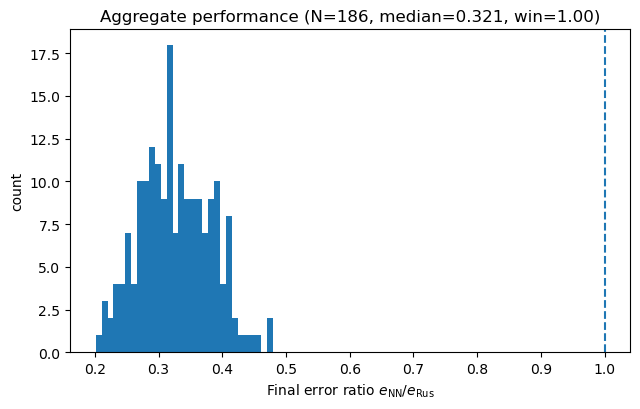

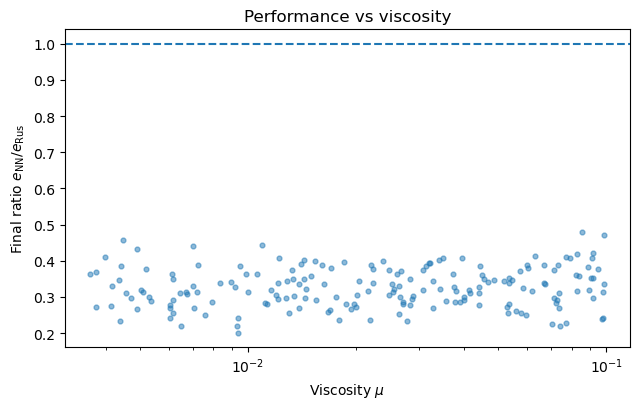

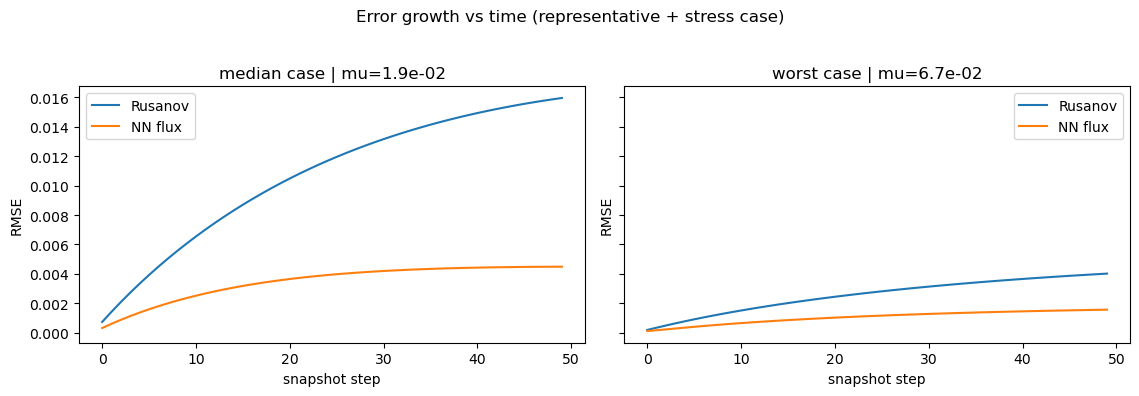

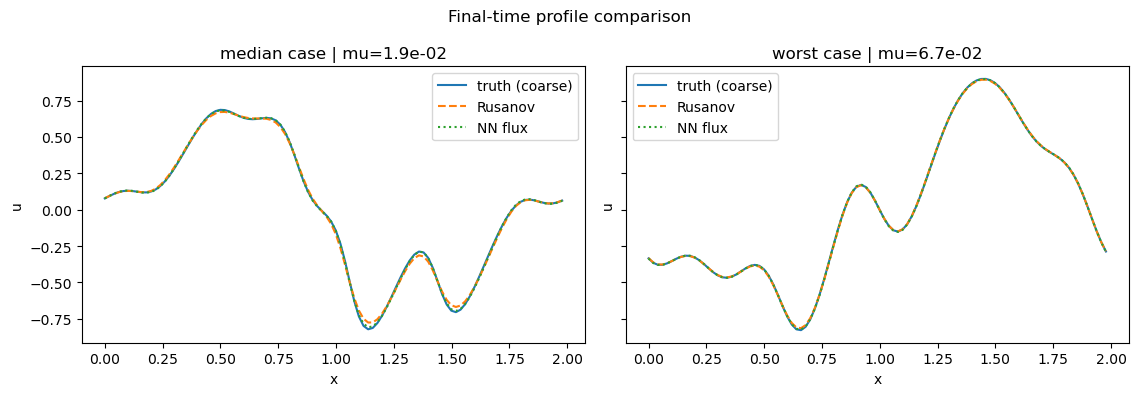

In [44]:
results, curves = evaluate_cases(coarse_cases, model=nn_model, K_eval=50, substeps=10,
                                 store_curves=True, store_max=20, plot_debug=False)

make_results_figures_4(results, curves, tag="results_stage6_4fig")

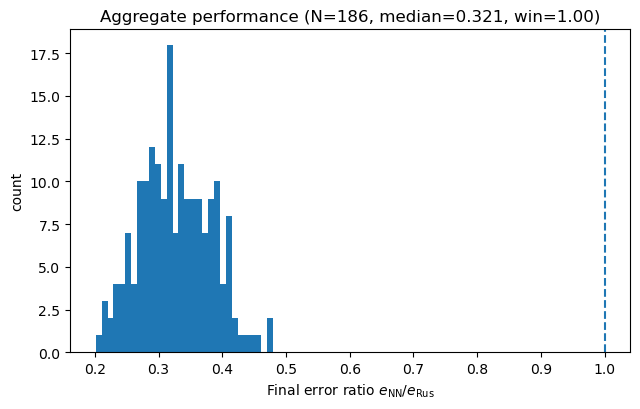

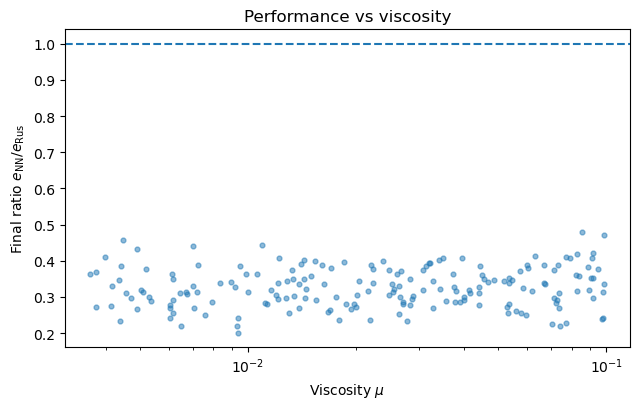

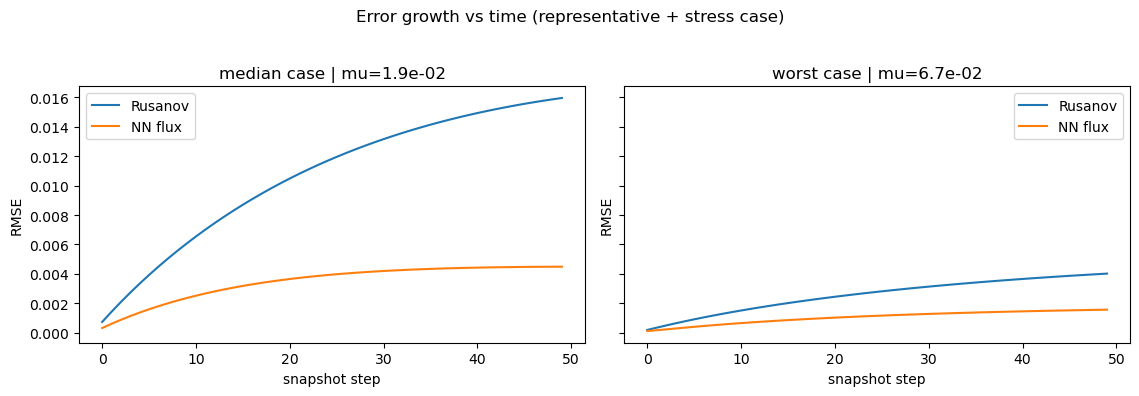

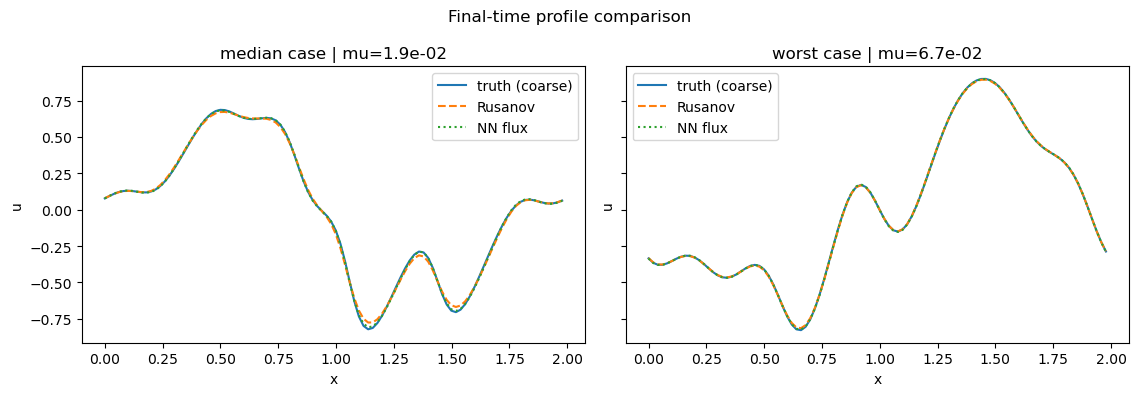

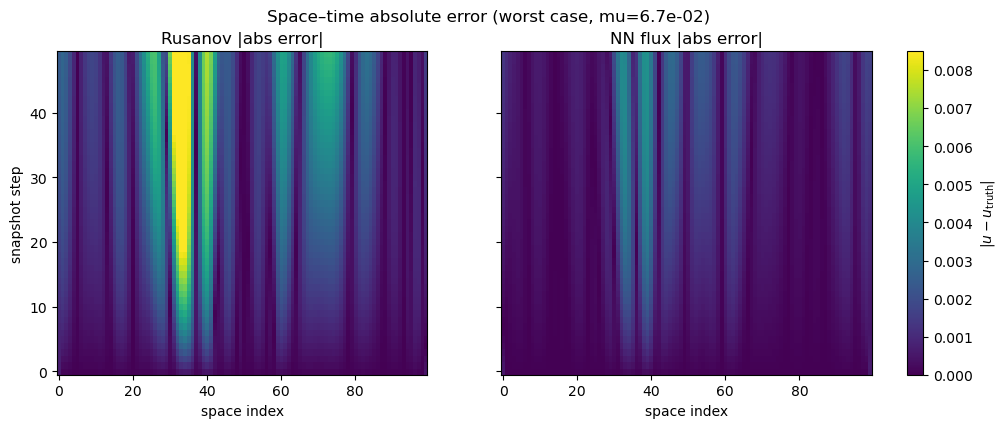

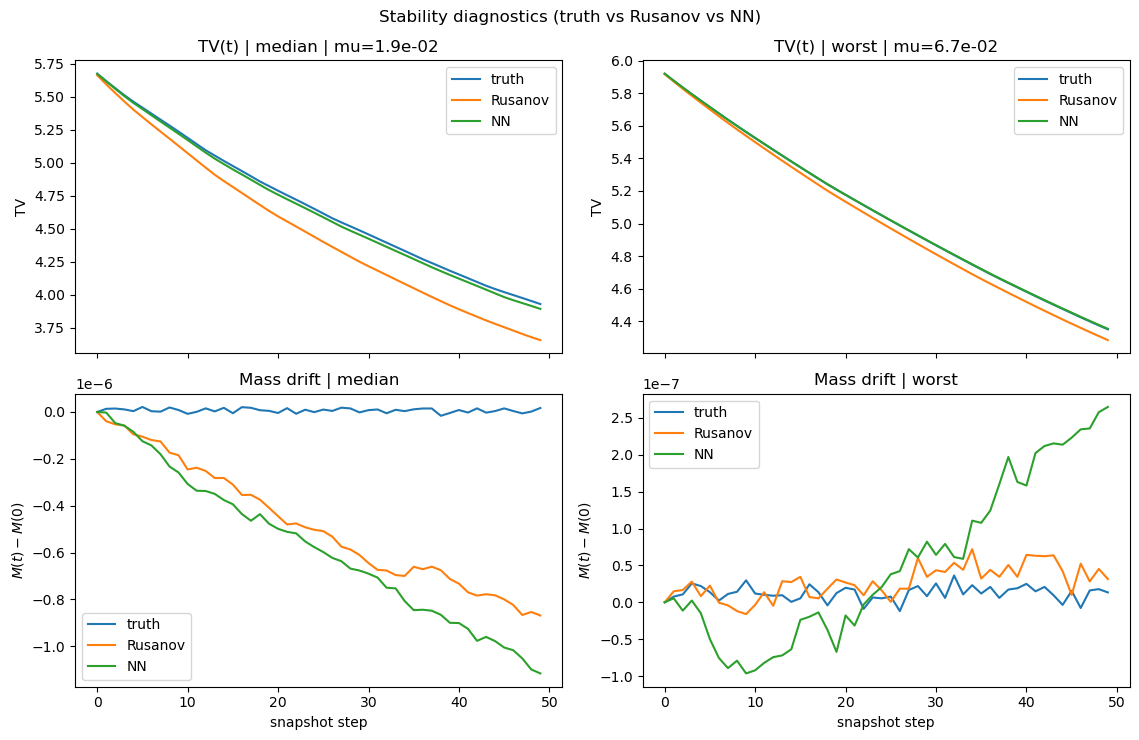

In [49]:
make_results_figures_6(results, curves, tag="results_stage6_6fig")

## PHASE 7

In [50]:
import pandas as pd

def split_by_mu_quantiles(coarse_cases, q_lo=0.1, q_hi=0.9):
    mus = np.array([c["mu"] for c in coarse_cases], dtype=float)
    lo = np.quantile(mus, q_lo)
    hi = np.quantile(mus, q_hi)
    in_dist = [c for c in coarse_cases if (c["mu"] >= lo and c["mu"] <= hi)]
    ood_low = [c for c in coarse_cases if c["mu"] < lo]
    ood_high = [c for c in coarse_cases if c["mu"] > hi]
    return dict(in_dist=in_dist, ood_low=ood_low, ood_high=ood_high, mu_lo=lo, mu_hi=hi)

def total_variation(u):
    # periodic TV (1D)
    return float(np.sum(np.abs(np.roll(u, -1) - u)))

def mass(u, dx):
    return float(np.sum(u) * dx)

def safe_rollout_metrics(u0, U_ref, dt, dx, mu, model, K_eval=50, substeps=10):
    """
    Wraps your existing rollout/eval logic and adds Phase-7 diagnostics.
    Assumes you already have something like rollout_compare / fv_rollout_nn inside your notebook.
    If your Phase-6 evaluate_cases already returns trajectories, use that instead.
    """
    # Use your existing function:
    # traj_nn, traj_ru = rollout_compare(u0, U_ref, dt, dx, mu, model)   # (K, N)
    traj_nn, traj_ru = rollout_compare(u0, U_ref, dt, dx, mu, model)   # must exist from Phase 6 cell

    # error vs reference at each step (relative L2)
    eps = 1e-12
    ref_norm = np.linalg.norm(U_ref[:traj_nn.shape[0]], axis=1) + eps
    err_nn = np.linalg.norm(traj_nn - U_ref[:traj_nn.shape[0]], axis=1) / ref_norm
    err_ru = np.linalg.norm(traj_ru - U_ref[:traj_ru.shape[0]], axis=1) / ref_norm

    # final-time stats
    u_nn_final = traj_nn[-1]
    u_ru_final = traj_ru[-1]
    u_ref_final = U_ref[traj_nn.shape[0]-1]

    tv_nn = total_variation(u_nn_final)
    tv_ru = total_variation(u_ru_final)
    tv_ref = total_variation(u_ref_final)

    m_nn = mass(u_nn_final, dx)
    m_ru = mass(u_ru_final, dx)
    m_ref = mass(u_ref_final, dx)

    return dict(
        K=int(traj_nn.shape[0]),
        err_nn_final=float(err_nn[-1]),
        err_ru_final=float(err_ru[-1]),
        ratio_final=float(err_nn[-1] / (err_ru[-1] + 1e-12)),
        err_nn_curve=err_nn,
        err_ru_curve=err_ru,
        tv_nn=float(tv_nn), tv_ru=float(tv_ru), tv_ref=float(tv_ref),
        mass_nn=float(m_nn), mass_ru=float(m_ru), mass_ref=float(m_ref),
        mass_drift_nn=float(m_nn - m_ref),
        mass_drift_ru=float(m_ru - m_ref),
        tv_ratio_nn=float(tv_nn / (tv_ref + 1e-12)),
        tv_ratio_ru=float(tv_ru / (tv_ref + 1e-12)),
    )


In [51]:
# ============================================================
# Phase 7 dataset (new ICs via new seed) - optional but recommended
# ============================================================
H5_PHASE7 = "Data/data_burgers_phase7_holdoutIC.h5"

if not os.path.exists(H5_PHASE7):
    make_dataset_h5(
        out_path=H5_PHASE7,
        num_cases=120,        # adjust
        N_fine=1000,          # match your previous N_fine for convenience
        domain=(-3.0, 3.0),   # match your notebook
        T=1.0,                # match your previous
        mu_min=1e-3,
        mu_max=1e-1,
        save_stride=20,
        seed=777,             # different seed = different IC distribution samples
    )
    print("Wrote:", H5_PHASE7)

cases_phase7 = load_cases_from_h5(H5_PHASE7)
print("Loaded holdout-IC cases:", len(cases_phase7))


Loaded holdout-IC cases: 120


In [52]:
N_LIST = [50, 100, 200]   # Phase 7 grid refinement

coarse_byN_trainIC = {N: build_coarse_cases(cases, N) for N in N_LIST}          # your original cases
coarse_byN_holdIC  = {N: build_coarse_cases(cases_phase7, N) for N in N_LIST}  # new ICs


In [53]:
def phase7_sweep(model, coarse_byN, horizons=(50, 100, 200), substeps=10, n_per_case=2, seed=0):
    rng = np.random.default_rng(seed)
    rows = []

    for N, coarse_cases in coarse_byN.items():
        split = split_by_mu_quantiles(coarse_cases, q_lo=0.1, q_hi=0.9)
        print(f"N={N}: in_dist={len(split['in_dist'])} ood_low={len(split['ood_low'])} ood_high={len(split['ood_high'])} "
              f"(mu_lo={split['mu_lo']:.2e}, mu_hi={split['mu_hi']:.2e})")

        for tag in ["in_dist", "ood_low", "ood_high"]:
            cases_subset = split[tag]
            if len(cases_subset) == 0:
                continue

            for c in cases_subset:
                U = c["Uc"]
                times = c["times"]
                dx = c["dx"]
                mu = c["mu"]

                # reference timestep between saved snapshots
                if U.shape[0] < 3:
                    continue
                dt = float(times[1] - times[0])

                for K_eval in horizons:
                    # need at least K_eval+1 steps after start
                    if U.shape[0] < (K_eval + 2):
                        continue

                    for _ in range(n_per_case):
                        # random start time (robustness to where you start)
                        n0 = int(rng.integers(0, U.shape[0] - (K_eval + 1)))
                        u0 = U[n0]
                        U_future = U[n0+1:n0+1+K_eval]

                        met = safe_rollout_metrics(u0, U_future, dt, dx, mu, model, K_eval=K_eval, substeps=substeps)
                        rows.append(dict(
                            N=N,
                            mu=mu,
                            mu_tag=tag,
                            K_eval=K_eval,
                            case=c["name"],
                            n0=n0,
                            **{k:v for k,v in met.items() if not k.endswith("_curve")}
                        ))

    return pd.DataFrame(rows)

# Run Phase 7 on training-IC distribution
df_trainIC = phase7_sweep(nn_model, coarse_byN_trainIC, horizons=(50, 100, 200), substeps=10, n_per_case=2, seed=0)
print(df_trainIC.shape)
display(df_trainIC.head())

# Run Phase 7 on holdout-IC distribution
df_holdIC = phase7_sweep(nn_model, coarse_byN_holdIC, horizons=(50, 100, 200), substeps=10, n_per_case=2, seed=1)
print(df_holdIC.shape)
display(df_holdIC.head())


N=50: in_dist=204 ood_low=26 ood_high=26 (mu_lo=1.42e-03, mu_hi=7.25e-02)
N=100: in_dist=204 ood_low=26 ood_high=26 (mu_lo=1.42e-03, mu_hi=7.25e-02)
N=200: in_dist=204 ood_low=26 ood_high=26 (mu_lo=1.42e-03, mu_hi=7.25e-02)
(2748, 20)


,N,mu,mu_tag,K_eval,case,n0,K,err_nn_final,err_ru_final,ratio_final,tv_nn,tv_ru,tv_ref,mass_nn,mass_ru,mass_ref,mass_drift_nn,mass_drift_ru,tv_ratio_nn,tv_ratio_ru
0,50,0.01879,in_dist,50,case_00000,179,50,0.013389,0.031415,0.426190,2.352519,2.269077,2.350959,0.000134,0.000134,0.000134,-5.701441e-08,-7.130523e-08,1.000663,0.965171
1,50,0.01879,in_dist,50,case_00000,134,50,0.010879,0.030612,0.355369,2.540326,2.430340,2.546518,0.000134,0.000134,0.000134,-1.315946e-07,-9.169942e-08,0.997569,0.954378
2,50,0.01879,in_dist,100,case_00000,82,100,0.015252,0.050213,0.303745,2.547229,2.364845,2.555214,0.000134,0.000134,0.000134,-7.294272e-08,-1.396332e-07,0.996875,0.925498
3,50,0.01879,in_dist,100,case_00000,43,100,0.014721,0.053789,0.273672,2.757019,2.515046,2.771108,0.000134,0.000134,0.000134,-1.625581e-07,-7.591998e-08,0.994916,0.907596
4,50,0.01879,in_dist,200,case_00000,18,200,0.023348,0.075503,0.309237,2.389190,2.191761,2.393943,0.000134,0.000134,0.000134,-5.269740e-08,-1.622603e-07,0.998015,0.915545


N=50: in_dist=96 ood_low=12 ood_high=12 (mu_lo=1.58e-03, mu_hi=6.18e-02)
N=100: in_dist=96 ood_low=12 ood_high=12 (mu_lo=1.58e-03, mu_hi=6.18e-02)
N=200: in_dist=96 ood_low=12 ood_high=12 (mu_lo=1.58e-03, mu_hi=6.18e-02)
(558, 20)


,N,mu,mu_tag,K_eval,case,n0,K,err_nn_final,err_ru_final,ratio_final,tv_nn,tv_ru,tv_ref,mass_nn,mass_ru,mass_ref,mass_drift_nn,mass_drift_ru,tv_ratio_nn,tv_ratio_ru
0,50,0.016680,in_dist,50,case_00000,0,50,0.098745,0.203990,0.484068,5.522674,3.755176,4.590632,0.001580,0.001580,0.001580,4.287241e-08,-7.859943e-08,1.203031,0.818008
1,50,0.016680,in_dist,50,case_00000,1,50,0.102808,0.201199,0.510976,5.525726,3.727961,4.549936,0.001580,0.001580,0.001580,1.786351e-07,-7.145402e-09,1.214462,0.819344
2,50,0.029655,in_dist,50,case_00005,31,50,0.026991,0.066579,0.405392,4.112004,3.720725,4.107929,-0.005547,-0.005547,-0.005547,-1.071810e-08,1.786351e-08,1.000992,0.905742
3,50,0.029655,in_dist,50,case_00005,39,50,0.025451,0.067637,0.376289,4.021138,3.654144,4.006710,-0.005548,-0.005547,-0.005547,-1.607716e-07,-2.143621e-08,1.003601,0.912006
4,50,0.032720,in_dist,50,case_00008,1,50,0.022005,0.065261,0.337185,3.749182,3.405396,3.770666,0.001175,0.001175,0.001175,-8.931753e-10,-3.778132e-07,0.994302,0.903129


In [54]:
def summarize_phase7(df, name=""):
    if df.empty:
        print("Empty DF:", name)
        return

    # overall win rate
    print(f"\n=== Phase 7 summary: {name} ===")
    print("Total runs:", len(df))
    print("Median ratio_final (NN/Rusanov):", float(df["ratio_final"].median()))
    print("Win-rate (ratio<1):", float((df["ratio_final"] < 1.0).mean()))

    # by grid/horizon/mu-tag
    g = df.groupby(["N","K_eval","mu_tag"])["ratio_final"].agg(["count","median","mean"])
    display(g)

summarize_phase7(df_trainIC, "train-IC")
summarize_phase7(df_holdIC,  "holdout-IC")



=== Phase 7 summary: train-IC ===
Total runs: 2748
Median ratio_final (NN/Rusanov): 0.34109087757207
Win-rate (ratio<1): 0.9970887918486172


count    median      mean
N   K_eval mu_tag                             
50  50     in_dist     320  0.378817  0.395190
           ood_high     52  0.477737  0.504064
    100    in_dist     252  0.375493  0.391665
           ood_high     52  0.490457  0.517114
    200    in_dist     188  0.391145  0.399560
           ood_high     52  0.499010  0.540874
100 50     in_dist     320  0.328871  0.335080
           ood_high     52  0.416335  0.420372
    100    in_dist     252  0.329443  0.335288
           ood_high     52  0.421922  0.430054
    200    in_dist     188  0.320278  0.334971
           ood_high     52  0.395745  0.416390
200 50     in_dist     320  0.304713  0.316434
           ood_high     52  0.345068  0.347824
    100    in_dist     252  0.301077  0.305873
           ood_high     52  0.339015  0.339744
    200    in_dist     188  0.296940  0.301513
           ood_high     52  0.310017  0.324860


=== Phase 7 summary: holdout-IC ===
Total runs: 558
Median ratio_final (NN/Rusanov): 0.3290015787113806
Win-rate (ratio<1): 1.0


count    median      mean
N   K_eval mu_tag                             
50  50     in_dist      78  0.399057  0.418144
           ood_high     24  0.342408  0.436909
    100    in_dist      42  0.401228  0.384615
           ood_high     24  0.375147  0.438010
    200    ood_high     18  0.371271  0.397237
100 50     in_dist      78  0.343365  0.343112
           ood_high     24  0.299774  0.347459
    100    in_dist      42  0.319196  0.311037
           ood_high     24  0.295765  0.349359
    200    ood_high     18  0.268660  0.303559
200 50     in_dist      78  0.312600  0.316005
           ood_high     24  0.293745  0.321349
    100    in_dist      42  0.295549  0.292927
           ood_high     24  0.290386  0.297057
    200    ood_high     18  0.223933  0.260256

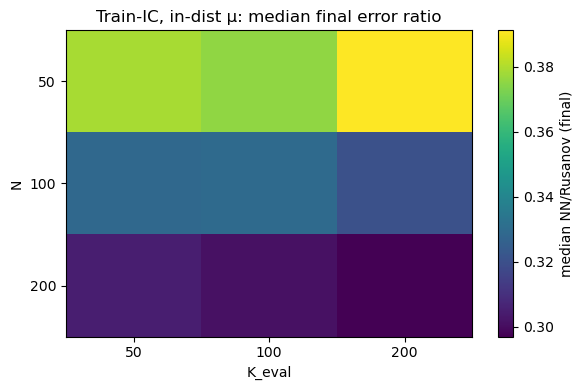

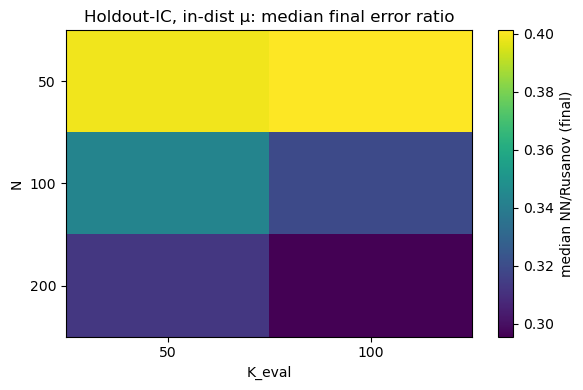

In [55]:
def heatmap_median_ratio(df, title):
    # pivot: rows N, cols K_eval (or vice versa)
    piv = df.groupby(["N","K_eval"])["ratio_final"].median().unstack()
    plt.figure(figsize=(6,4))
    plt.imshow(piv.values, aspect="auto")
    plt.xticks(np.arange(piv.shape[1]), piv.columns)
    plt.yticks(np.arange(piv.shape[0]), piv.index)
    plt.colorbar(label="median NN/Rusanov (final)")
    plt.xlabel("K_eval")
    plt.ylabel("N")
    plt.title(title)
    plt.tight_layout()
    plt.show()

heatmap_median_ratio(df_trainIC[df_trainIC.mu_tag=="in_dist"], "Train-IC, in-dist μ: median final error ratio")
heatmap_median_ratio(df_holdIC[df_holdIC.mu_tag=="in_dist"],  "Holdout-IC, in-dist μ: median final error ratio")


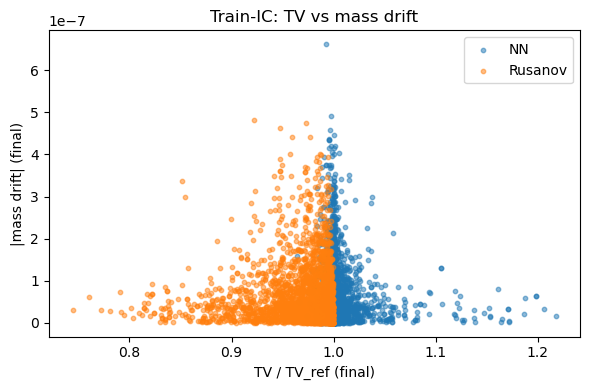

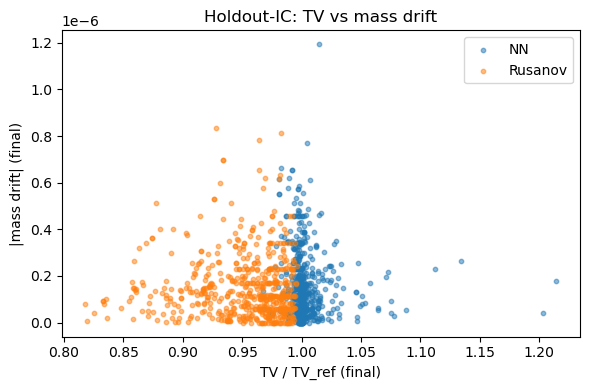

In [56]:
def tv_mass_scatter(df, title):
    plt.figure(figsize=(6,4))
    plt.scatter(df["tv_ratio_nn"], np.abs(df["mass_drift_nn"]), s=10, alpha=0.5, label="NN")
    plt.scatter(df["tv_ratio_ru"], np.abs(df["mass_drift_ru"]), s=10, alpha=0.5, label="Rusanov")
    plt.xlabel("TV / TV_ref (final)")
    plt.ylabel("|mass drift| (final)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

tv_mass_scatter(df_trainIC, "Train-IC: TV vs mass drift")
tv_mass_scatter(df_holdIC,  "Holdout-IC: TV vs mass drift")


,N,K_eval,mu_tag,mu,case,n0,ratio_final,err_nn_final,err_ru_final,tv_ratio_nn,mass_drift_nn
179,50,100,ood_high,0.062458,case_00116,34,0.893322,0.028389,0.031779,0.997954,-5.843599e-07
176,50,50,ood_high,0.062458,case_00116,65,0.793819,0.019963,0.025148,0.997637,-6.073592e-08
170,50,50,ood_high,0.087081,case_00093,190,0.790530,0.019786,0.025029,1.013038,4.465877e-08


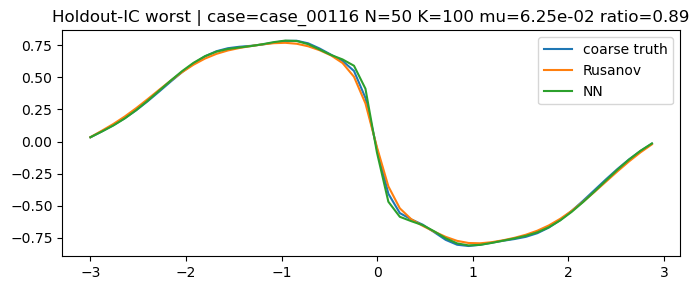

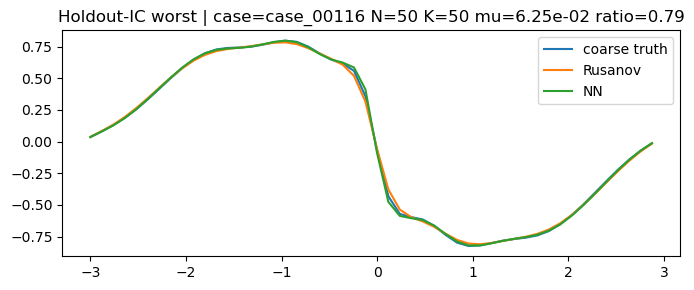

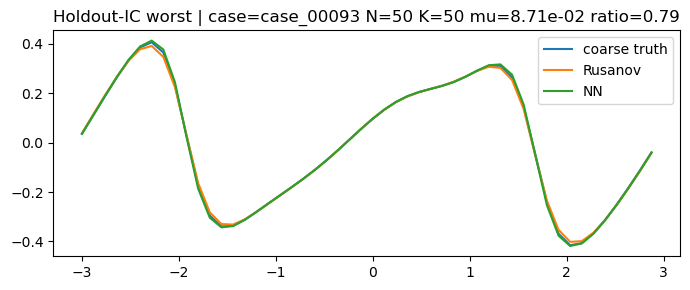

In [57]:
def show_worst_cases(df, coarse_byN, model, topk=3, title=""):
    if df.empty:
        return
    worst = df.sort_values("ratio_final", ascending=False).head(topk)
    display(worst[["N","K_eval","mu_tag","mu","case","n0","ratio_final","err_nn_final","err_ru_final","tv_ratio_nn","mass_drift_nn"]])

    for _, r in worst.iterrows():
        N = int(r["N"]); K_eval=int(r["K_eval"]); case_name=r["case"]; n0=int(r["n0"])
        # recover the case
        cands = [c for c in coarse_byN[N] if c["name"] == case_name]
        if not cands:
            continue
        c = cands[0]
        U = c["Uc"]; times=c["times"]; dx=c["dx"]; mu=c["mu"]
        dt=float(times[1]-times[0])
        u0 = U[n0]
        U_future = U[n0+1:n0+1+K_eval]

        traj_nn, traj_ru = rollout_compare(u0, U_future, dt, dx, mu, model)

        # Plot final profiles
        x = c["x"]
        plt.figure(figsize=(7,3))
        plt.plot(x, U_future[len(traj_nn)-1], label="coarse truth")
        plt.plot(x, traj_ru[-1], label="Rusanov")
        plt.plot(x, traj_nn[-1], label="NN")
        plt.title(f"{title} | case={case_name} N={N} K={len(traj_nn)} mu={mu:.2e} ratio={r['ratio_final']:.2f}")
        plt.legend(); plt.tight_layout(); plt.show()

show_worst_cases(df_holdIC, coarse_byN_holdIC, nn_model, topk=3, title="Holdout-IC worst")


In [58]:
def entropy_quadratic(u, dx):
    # E = ∫ 1/2 u^2 dx (periodic)
    u = np.asarray(u)
    return float(0.5 * np.sum(u*u) * dx)

def mass(u, dx):
    u = np.asarray(u)
    return float(np.sum(u) * dx)

def total_variation(u):
    u = np.asarray(u)
    return float(np.sum(np.abs(np.roll(u, -1) - u)))

def entropy_curve(traj, dx):
    # traj: (K, N)
    return np.array([entropy_quadratic(traj[k], dx) for k in range(traj.shape[0])], dtype=float)

def tv_curve(traj):
    return np.array([total_variation(traj[k]) for k in range(traj.shape[0])], dtype=float)

def mass_curve(traj, dx):
    return np.array([mass(traj[k], dx) for k in range(traj.shape[0])], dtype=float)

def monotonicity_violations(arr, tol=1e-12):
    """
    For a curve that 'should' be non-increasing (e.g., entropy for viscous Burgers),
    count positive jumps.
    """
    d = np.diff(arr)
    return int(np.sum(d > tol)), d


In [59]:
def rollout_metrics_with_entropy(u0, U_ref, dt, dx, mu, model, name=None):
    """
    u0: (N,)
    U_ref: (K, N)  reference future trajectory (coarse truth)
    returns dict with scalar metrics + curves
    """
    traj_nn, traj_ru = rollout_compare(u0, U_ref, dt, dx, mu, model)  # your function

    # error curves vs reference
    eps = 1e-12
    ref_norm = np.linalg.norm(U_ref, axis=1) + eps
    err_nn = np.linalg.norm(traj_nn - U_ref, axis=1) / ref_norm
    err_ru = np.linalg.norm(traj_ru - U_ref, axis=1) / ref_norm

    # entropy curves
    E_ref = entropy_curve(U_ref, dx)
    E_nn  = entropy_curve(traj_nn, dx)
    E_ru  = entropy_curve(traj_ru, dx)

    # TV curves
    TV_ref = tv_curve(U_ref)
    TV_nn  = tv_curve(traj_nn)
    TV_ru  = tv_curve(traj_ru)

    # mass curves
    M_ref = mass_curve(U_ref, dx)
    M_nn  = mass_curve(traj_nn, dx)
    M_ru  = mass_curve(traj_ru, dx)

    # entropy monotonicity “sanity” (viscous Burgers should dissipate)
    viol_nn, dE_nn = monotonicity_violations(E_nn)
    viol_ru, dE_ru = monotonicity_violations(E_ru)

    out = dict(
        name=name,
        K=int(U_ref.shape[0]),
        mu=float(mu),
        dt=float(dt),
        dx=float(dx),

        err_nn_final=float(err_nn[-1]),
        err_ru_final=float(err_ru[-1]),
        ratio_final=float(err_nn[-1] / (err_ru[-1] + 1e-12)),

        # entropy endpoints
        E_ref0=float(E_ref[0]), E_ref_final=float(E_ref[-1]),
        E_nn0=float(E_nn[0]),   E_nn_final=float(E_nn[-1]),
        E_ru0=float(E_ru[0]),   E_ru_final=float(E_ru[-1]),

        # relative entropy decay (positive means decayed)
        dE_ref=float(E_ref[0] - E_ref[-1]),
        dE_nn=float(E_nn[0] - E_nn[-1]),
        dE_ru=float(E_ru[0] - E_ru[-1]),

        entropy_violations_nn=int(viol_nn),
        entropy_violations_ru=int(viol_ru),

        # TV endpoints
        TV_ref_final=float(TV_ref[-1]),
        TV_nn_final=float(TV_nn[-1]),
        TV_ru_final=float(TV_ru[-1]),
        TV_ratio_nn=float(TV_nn[-1] / (TV_ref[-1] + 1e-12)),
        TV_ratio_ru=float(TV_ru[-1] / (TV_ref[-1] + 1e-12)),

        # mass drift at final time
        mass_ref_final=float(M_ref[-1]),
        mass_nn_final=float(M_nn[-1]),
        mass_ru_final=float(M_ru[-1]),
        mass_drift_nn=float(M_nn[-1] - M_ref[-1]),
        mass_drift_ru=float(M_ru[-1] - M_ref[-1]),

        # curves for plotting
        err_nn_curve=err_nn, err_ru_curve=err_ru,
        E_ref_curve=E_ref, E_nn_curve=E_nn, E_ru_curve=E_ru,
        TV_ref_curve=TV_ref, TV_nn_curve=TV_nn, TV_ru_curve=TV_ru,
        M_ref_curve=M_ref, M_nn_curve=M_nn, M_ru_curve=M_ru,
    )
    return out


In [60]:
def split_by_mu_quantiles(coarse_cases, q_lo=0.1, q_hi=0.9):
    mus = np.array([c["mu"] for c in coarse_cases], dtype=float)
    lo = np.quantile(mus, q_lo)
    hi = np.quantile(mus, q_hi)
    in_dist = [c for c in coarse_cases if (c["mu"] >= lo and c["mu"] <= hi)]
    ood_low = [c for c in coarse_cases if c["mu"] < lo]
    ood_high = [c for c in coarse_cases if c["mu"] > hi]
    return dict(in_dist=in_dist, ood_low=ood_low, ood_high=ood_high, mu_lo=lo, mu_hi=hi)

def phase7_sweep_entropy(model, coarse_byN, horizons=(50,100,200), n_per_case=2, seed=0):
    rng = np.random.default_rng(seed)
    rows = []
    curves_store = []  # keep curves for worst-case plotting

    for N, coarse_cases in coarse_byN.items():
        split = split_by_mu_quantiles(coarse_cases, q_lo=0.1, q_hi=0.9)
        print(f"N={N}: in_dist={len(split['in_dist'])} ood_low={len(split['ood_low'])} ood_high={len(split['ood_high'])} "
              f"(mu_lo={split['mu_lo']:.2e}, mu_hi={split['mu_hi']:.2e})")

        for mu_tag in ["in_dist","ood_low","ood_high"]:
            cases_subset = split[mu_tag]
            if len(cases_subset) == 0:
                continue

            for c in cases_subset:
                U = c["Uc"]         # (Nt, N)
                times = c["times"]
                dx = c["dx"]
                mu = c["mu"]

                if U.shape[0] < 3:
                    continue
                dt = float(times[1] - times[0])

                for K_eval in horizons:
                    if U.shape[0] < (K_eval + 2):
                        continue

                    for rep in range(n_per_case):
                        n0 = int(rng.integers(0, U.shape[0] - (K_eval + 1)))
                        u0 = U[n0]
                        U_future = U[n0+1:n0+1+K_eval]

                        met = rollout_metrics_with_entropy(
                            u0=u0, U_ref=U_future, dt=dt, dx=dx, mu=mu, model=model,
                            name=c.get("name", None)
                        )

                        row = dict(
                            N=int(N),
                            mu_tag=mu_tag,
                            case=c.get("name", ""),
                            n0=int(n0),
                            rep=int(rep),
                            K_eval=int(K_eval),
                            # scalars only:
                            **{k:v for k,v in met.items() if not k.endswith("_curve")}
                        )
                        rows.append(row)

                        # store curves for later deep-dive
                        curves_store.append(dict(
                            key=(row["case"], row["N"], row["K_eval"], row["n0"], row["rep"]),
                            x=c["x"],
                            met=met
                        ))

    df = pd.DataFrame(rows)
    return df, curves_store


In [ ]:
def phase7_report(df, curves_store, title="Phase 7"):
    if df.empty:
        print("Empty results.")
        return

    print("\n" + "="*80)
    print(f"{title} — SUMMARY")
    print("="*80)
    print("Total runs:", len(df))
    print("Median ratio_final (NN/Rusanov):", float(df["ratio_final"].median()))
    print("Win rate (ratio_final < 1):", float((df["ratio_final"] < 1.0).mean()))
    print("Entropy violations (NN):", int(df["entropy_violations_nn"].sum()), "out of", len(df),
          "(fraction:", float((df["entropy_violations_nn"]>0).mean()), ")")
    print("Entropy violations (Rusanov):", int(df["entropy_violations_ru"].sum()), "out of", len(df),
          "(fraction:", float((df["entropy_violations_ru"]>0).mean()), ")")
    print("Median |mass drift| NN:", float(np.median(np.abs(df["mass_drift_nn"]))),
          " Rusanov:", float(np.median(np.abs(df["mass_drift_ru"]))))

    # by group
    g = df.groupby(["mu_tag","N","K_eval"])["ratio_final"].agg(["count","median","mean"])
    display(g)

    # Heatmap: median ratio per (N, K)
    piv = df.groupby(["N","K_eval"])["ratio_final"].median().unstack()
    plt.figure(figsize=(6,4))
    plt.imshow(piv.values, aspect="auto")
    plt.xticks(np.arange(piv.shape[1]), piv.columns)
    plt.yticks(np.arange(piv.shape[0]), piv.index)
    plt.colorbar(label="median NN/Rusanov final error")
    plt.xlabel("K_eval")
    plt.ylabel("N")
    plt.title(f"{title}: median error ratio")
    plt.tight_layout()
    plt.show()

    # Scatter: error ratio vs TV ratio (detect over/under dissipation)
    plt.figure(figsize=(6,4))
    plt.scatter(df["TV_ratio_nn"], df["ratio_final"], s=10, alpha=0.4)
    plt.axvline(1.0, linestyle="--")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("TV_ratio_nn = TV_nn/TV_ref (final)")
    plt.ylabel("ratio_final = err_nn/err_ru (final)")
    plt.title(f"{title}: dissipation vs performance")
    plt.tight_layout()
    plt.show()

    # Worst cases (largest ratio)
    worst = df.sort_values("ratio_final", ascending=False).head(5)
    print("\nWorst 5 cases by ratio_final:")
    display(worst[["mu_tag","N","K_eval","mu","case","n0","rep","ratio_final","err_nn_final","err_ru_final",
                  "entropy_violations_nn","TV_ratio_nn","mass_drift_nn"]])

    # Helper to fetch stored curves
    store = {d["key"]: d for d in curves_store}

    def plot_case(row, label):
        key = (row["case"], row["N"], row["K_eval"], row["n0"], row["rep"])
        item = store.get(key, None)
        if item is None:
            print("Missing curves for key:", key)
            return
        met = item["met"]
        x = item["x"]

        t = np.arange(met["K"])  # step index

        plt.figure(figsize=(7,3))
        plt.plot(t, met["err_ru_curve"], label="Rusanov error")
        plt.plot(t, met["err_nn_curve"], label="NN error")
        plt.yscale("log")
        plt.xlabel("step")
        plt.ylabel("relative L2 error vs coarse truth")
        plt.title(f"{label}: error growth | N={row['N']} K={row['K_eval']} mu={row['mu']:.2e} ratio={row['ratio_final']:.2f}")
        plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(7,3))
        plt.plot(t, met["E_ref_curve"], label="truth entropy")
        plt.plot(t, met["E_ru_curve"], label="Rusanov entropy")
        plt.plot(t, met["E_nn_curve"], label="NN entropy")
        plt.xlabel("step")
        plt.ylabel("E = ∫ 1/2 u^2 dx")
        plt.title(f"{label}: entropy curve (should generally decrease)")
        plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(7,3))
        plt.plot(t, met["TV_ref_curve"], label="truth TV")
        plt.plot(t, met["TV_ru_curve"], label="Rusanov TV")
        plt.plot(t, met["TV_nn_curve"], label="NN TV")
        plt.xlabel("step")
        plt.ylabel("TV")
        plt.title(f"{label}: TV curve")
        plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(7,3))
        plt.plot(t, met["M_ref_curve"], label="truth mass")
        plt.plot(t, met["M_ru_curve"], label="Rusanov mass")
        plt.plot(t, met["M_nn_curve"], label="NN mass")
        plt.xlabel("step")
        plt.ylabel("mass")
        plt.title(f"{label}: mass (should be flat; drift indicates a bug)")
        plt.legend(); plt.tight_layout(); plt.show()

    # Plot top 2 worst for deep-dive
    for i, (_, r) in enumerate(worst.head(2).iterrows(), start=1):
        plot_case(r, f"{title} worst #{i}")


N=50: in_dist=96 ood_low=12 ood_high=12 (mu_lo=1.58e-03, mu_hi=6.18e-02)
N=100: in_dist=96 ood_low=12 ood_high=12 (mu_lo=1.58e-03, mu_hi=6.18e-02)
N=200: in_dist=96 ood_low=12 ood_high=12 (mu_lo=1.58e-03, mu_hi=6.18e-02)

Phase 7 — Holdout IC — SUMMARY
Total runs: 558
Median ratio_final (NN/Rusanov): 0.3290015787113806
Win rate (ratio_final < 1): 1.0
Entropy violations (NN): 0 out of 558 (fraction: 0.0 )
Entropy violations (Rusanov): 0 out of 558 (fraction: 0.0 )
Median |mass drift| NN: 1.1789937559569807e-07  Rusanov: 1.143262124969624e-07


count    median      mean
mu_tag   N   K_eval                           
in_dist  50  50         78  0.399057  0.418144
             100        42  0.401228  0.384615
         100 50         78  0.343365  0.343112
             100        42  0.319196  0.311037
         200 50         78  0.312600  0.316005
             100        42  0.295549  0.292927
ood_high 50  50         24  0.342408  0.436909
             100        24  0.375147  0.438010
             200        18  0.371271  0.397237
         100 50         24  0.299774  0.347459
             100        24  0.295765  0.349359
             200        18  0.268660  0.303559
         200 50         24  0.293745  0.321349
             100        24  0.290386  0.297057
             200        18  0.223933  0.260256

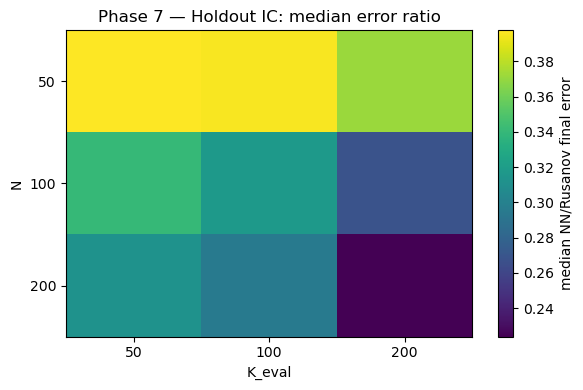

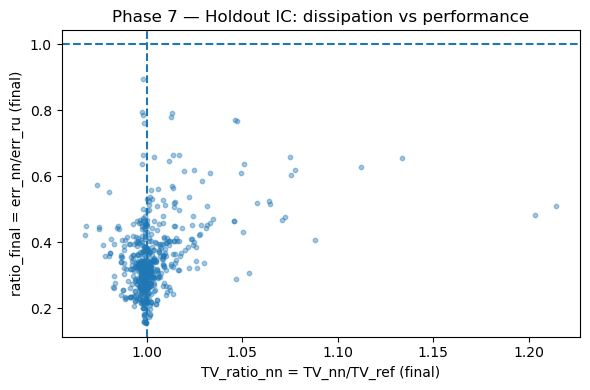


Worst 5 cases by ratio_final:


,mu_tag,N,K_eval,mu,case,n0,rep,ratio_final,err_nn_final,err_ru_final,entropy_violations_nn,TV_ratio_nn,mass_drift_nn
179,ood_high,50,100,0.062458,case_00116,34,1,0.893322,0.028389,0.031779,0,0.997954,-5.843599e-07
176,ood_high,50,50,0.062458,case_00116,65,0,0.793819,0.019963,0.025148,0,0.997637,-6.073592e-08
170,ood_high,50,50,0.087081,case_00093,190,0,0.790530,0.019786,0.025029,0,1.013038,4.465877e-08
178,ood_high,50,100,0.062458,case_00116,13,0,0.785047,0.030426,0.038757,0,0.997864,-1.921443e-07
171,ood_high,50,50,0.087081,case_00093,182,1,0.778737,0.020264,0.026021,0,1.012848,1.299570e-07


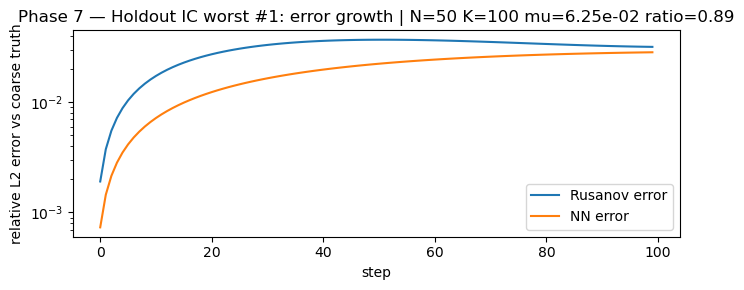

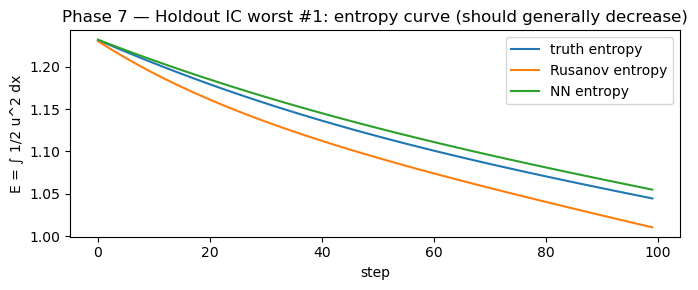

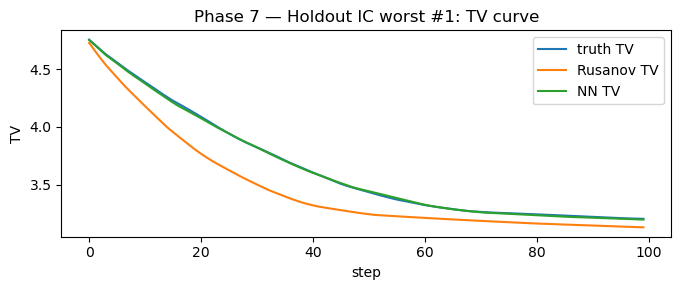

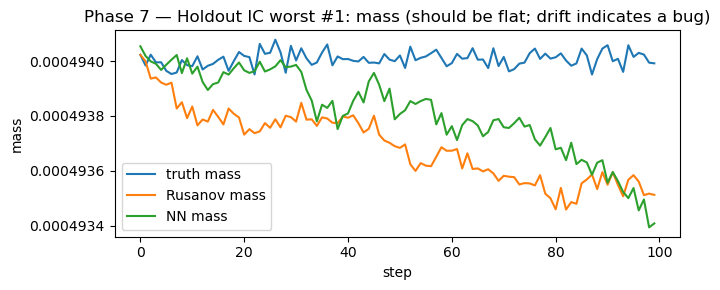

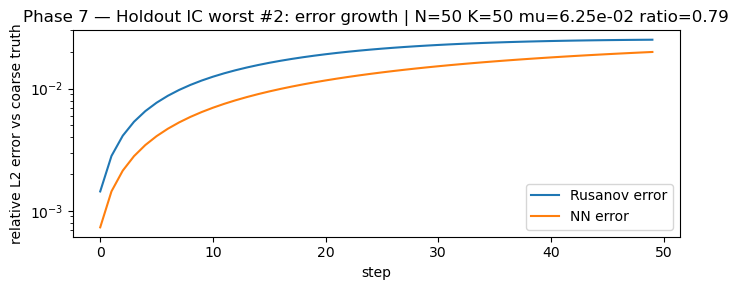

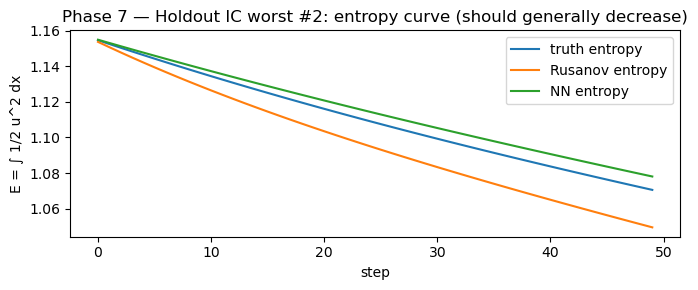

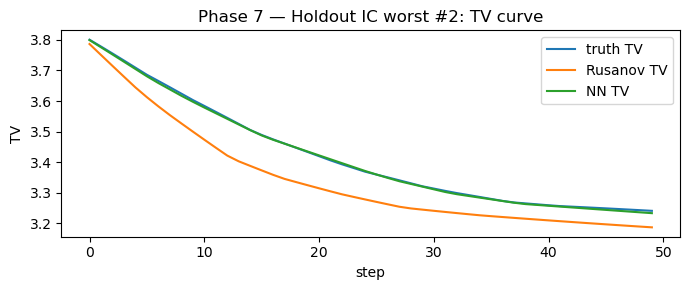

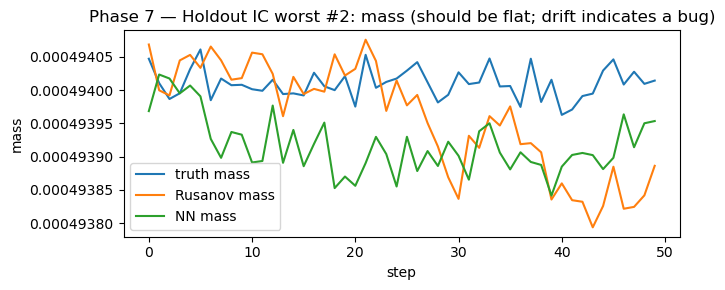

In [62]:
# Example: evaluate holdout IC suite
df_holdIC7, curves_holdIC7 = phase7_sweep_entropy(
    model=nn_model,
    coarse_byN=coarse_byN_holdIC,
    horizons=(50,100,200),
    n_per_case=2,
    seed=1
)

phase7_report(df_holdIC7, curves_holdIC7, title="Phase 7 — Holdout IC")


N=50: in_dist=204 ood_low=26 ood_high=26 (mu_lo=1.42e-03, mu_hi=7.25e-02)
N=100: in_dist=204 ood_low=26 ood_high=26 (mu_lo=1.42e-03, mu_hi=7.25e-02)
N=200: in_dist=204 ood_low=26 ood_high=26 (mu_lo=1.42e-03, mu_hi=7.25e-02)

Phase 7 — Train IC — SUMMARY
Total runs: 2748
Median ratio_final (NN/Rusanov): 0.34109087757207
Win rate (ratio_final < 1): 0.9970887918486172
Entropy violations (NN): 0 out of 2748 (fraction: 0.0 )
Entropy violations (Rusanov): 0 out of 2748 (fraction: 0.0 )
Median |mass drift| NN: 4.436108458349963e-08  Rusanov: 4.004406628510537e-08


count    median      mean
mu_tag   N   K_eval                           
in_dist  50  50        320  0.378817  0.395190
             100       252  0.375493  0.391665
             200       188  0.391145  0.399560
         100 50        320  0.328871  0.335080
             100       252  0.329443  0.335288
             200       188  0.320278  0.334971
         200 50        320  0.304713  0.316434
             100       252  0.301077  0.305873
             200       188  0.296940  0.301513
ood_high 50  50         52  0.477737  0.504064
             100        52  0.490457  0.517114
             200        52  0.499010  0.540874
         100 50         52  0.416335  0.420372
             100        52  0.421922  0.430054
             200        52  0.395745  0.416390
         200 50         52  0.345068  0.347824
             100        52  0.339015  0.339744
             200        52  0.310017  0.324860

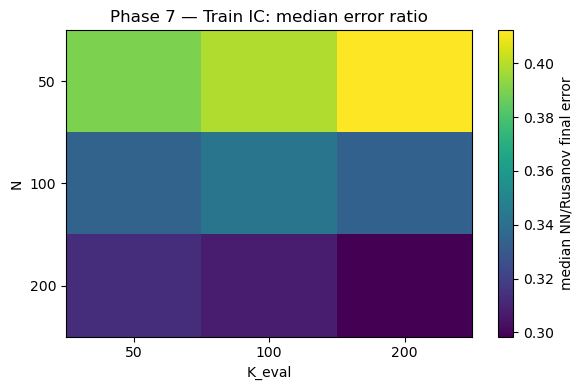

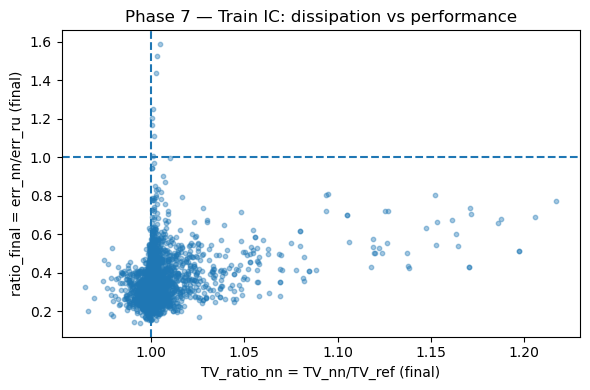


Worst 5 cases by ratio_final:


,mu_tag,N,K_eval,mu,case,n0,rep,ratio_final,err_nn_final,err_ru_final,entropy_violations_nn,TV_ratio_nn,mass_drift_nn
879,ood_high,50,200,0.091972,case_00183,498,1,1.587901,0.004925,0.003101,0,1.004900,5.716328e-08
878,ood_high,50,200,0.091972,case_00183,626,0,1.526019,0.003738,0.002450,0,1.003090,5.478147e-08
877,ood_high,50,100,0.091972,case_00183,612,1,1.440524,0.002380,0.001652,0,1.002360,1.012266e-08
876,ood_high,50,100,0.091972,case_00183,928,0,1.250425,0.001344,0.001075,0,1.001151,-1.607717e-08
875,ood_high,50,50,0.091972,case_00183,899,1,1.206642,0.000751,0.000622,0,1.000679,-4.763606e-09


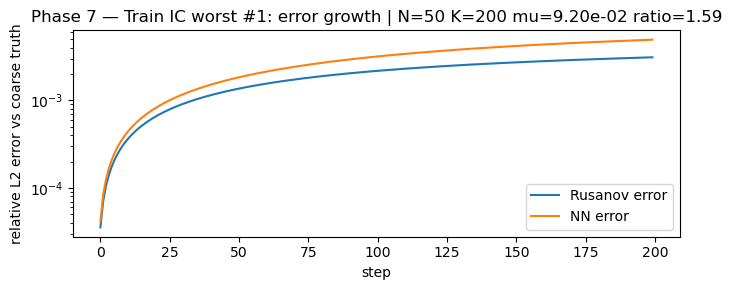

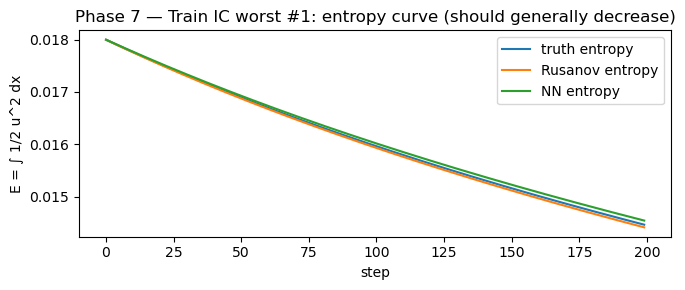

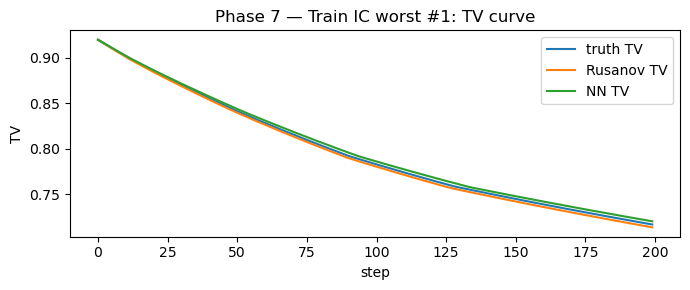

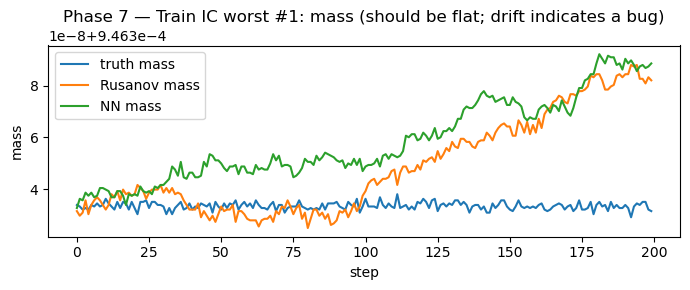

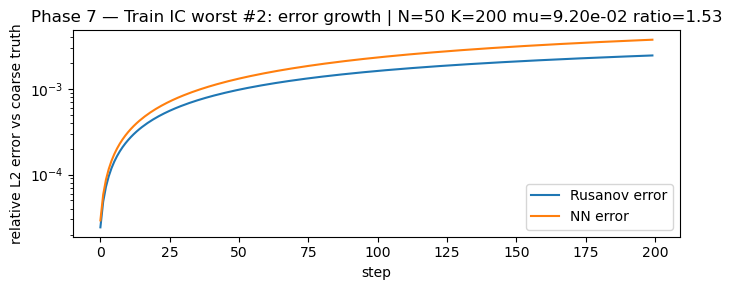

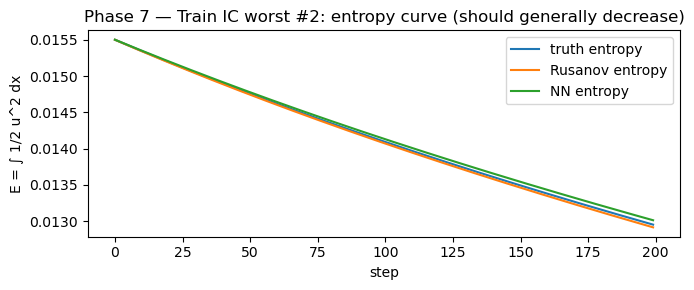

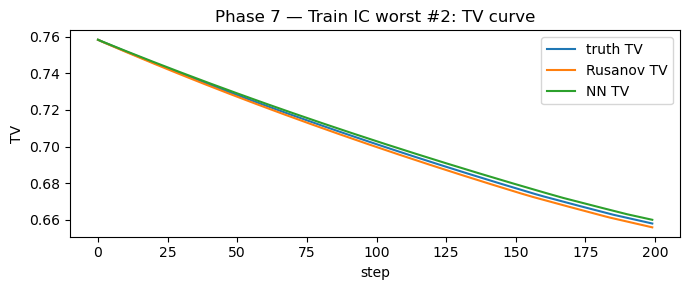

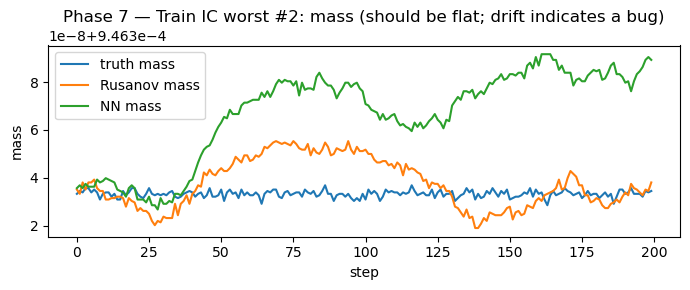

In [63]:
df_trainIC7, curves_trainIC7 = phase7_sweep_entropy(
    model=nn_model,
    coarse_byN=coarse_byN_trainIC,
    horizons=(50,100,200),
    n_per_case=2,
    seed=0
)

phase7_report(df_trainIC7, curves_trainIC7, title="Phase 7 — Train IC")


In [69]:
def phase7_report_v2(df, curves_store, title="Phase 7", n_deep=2, save_tag="phase7"):
    if df.empty:
        print("Empty results.")
        return

    print("\n" + "="*80)
    print(f"{title} — SUMMARY")
    print("="*80)
    print("Total runs:", len(df))
    print("Median ratio_final (NN/Rusanov):", float(df["ratio_final"].median()))
    print("Win rate (ratio_final < 1):", float((df["ratio_final"] < 1.0).mean()))
    print("Entropy violations (NN):", int(df["entropy_violations_nn"].sum()), "out of", len(df),
          "(fraction:", float((df["entropy_violations_nn"]>0).mean()), ")")
    print("Entropy violations (Rusanov):", int(df["entropy_violations_ru"].sum()), "out of", len(df),
          "(fraction:", float((df["entropy_violations_ru"]>0).mean()), ")")
    print("Median |mass drift| NN:", float(np.median(np.abs(df["mass_drift_nn"]))),
          " Rusanov:", float(np.median(np.abs(df["mass_drift_ru"]))))

    # group table
    g = df.groupby(["mu_tag","N","K_eval"])["ratio_final"].agg(["count","median","mean"]).sort_values(["mu_tag","N","K_eval"])
    display(g)

    # Heatmap: median ratio per (N, K)
    piv = df.groupby(["N","K_eval"])["ratio_final"].median().unstack()
    fig = plt.figure(figsize=(6.5,4.2))
    plt.imshow(piv.values, aspect="auto", origin="lower")
    plt.xticks(np.arange(piv.shape[1]), piv.columns)
    plt.yticks(np.arange(piv.shape[0]), piv.index)
    plt.colorbar(label="median NN/Rusanov final error")
    plt.xlabel("K_eval")
    plt.ylabel("N")
    plt.title(f"{title}: median error ratio heatmap")
    plt.tight_layout()
    savefig(fig, f"{save_tag}_heatmap_median_ratio")
    plt.show()

    # Scatter: error ratio vs TV ratio
    fig = plt.figure(figsize=(6.5,4.2))
    plt.scatter(df["TV_ratio_nn"], df["ratio_final"], s=12, alpha=0.4)
    plt.axvline(1.0, linestyle="--")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("TV_ratio_nn = TV_nn/TV_ref (final)")
    plt.ylabel("ratio_final = err_nn/err_ru (final)")
    plt.title(f"{title}: dissipation vs performance")
    plt.tight_layout()
    savefig(fig, f"{save_tag}_scatter_tv_vs_ratio")
    plt.show()

    # worst table
    worst = df.sort_values("ratio_final", ascending=False).head(5)
    print("\nWorst 5 cases by ratio_final:")
    display(worst[["mu_tag","N","K_eval","mu","case","n0","rep","ratio_final","err_nn_final","err_ru_final",
                  "entropy_violations_nn","TV_ratio_nn","mass_drift_nn"]])

    # store lookup
    store = {d["key"]: d for d in curves_store}

    # choose deep-dive rows: worst and median
    df_sorted = df.sort_values("ratio_final", ascending=False).reset_index(drop=True)
    rows = [df_sorted.iloc[0], df_sorted.iloc[len(df_sorted)//2]]

    def plot_case_row(row, label):
        key = (row["case"], row["N"], row["K_eval"], row["n0"], row["rep"])
        item = store.get(key, None)
        if item is None:
            print("Missing curves for key:", key)
            return
        met = item["met"]
        K = int(met["K"])
        t = np.arange(K)

        fig, axes = plt.subplots(2, 2, figsize=(12,7.2))
        fig.suptitle(
            f"{label} | N={row['N']} K={row['K_eval']} mu={row['mu']:.2e} "
            f"ratio={row['ratio_final']:.2f} | entropyViolNN={int(row['entropy_violations_nn'])}",
            fontsize=12
        )

        # (1) error curves (log)
        ax = axes[0,0]
        ax.plot(t, met["err_ru_curve"], label="Rusanov")
        ax.plot(t, met["err_nn_curve"], label="NN")
        ax.set_yscale("log")
        ax.set_xlabel("step")
        ax.set_ylabel("rel L2 error vs coarse truth")
        ax.set_title("Error growth (log scale)")
        ax.legend()

        # (2) ratio curve
        ax = axes[0,1]
        ratio = np.asarray(met["err_nn_curve"]) / (np.asarray(met["err_ru_curve"]) + 1e-12)
        ax.plot(t, ratio, label="NN/Rusanov")
        ax.axhline(1.0, linestyle="--")
        ax.set_xlabel("step")
        ax.set_ylabel("error ratio")
        ax.set_title("Relative error (NN / Rusanov)")
        ax.legend()

        # (3) entropy curve
        ax = axes[1,0]
        # your met keys: you used E_* in the code you pasted
        ax.plot(t, met["E_ref_curve"], label="truth")
        ax.plot(t, met["E_ru_curve"], label="Rusanov")
        ax.plot(t, met["E_nn_curve"], label="NN")
        ax.set_xlabel("step")
        ax.set_ylabel(r"$E=\int \frac{1}{2} u^2\,dx$")
        ax.set_title("Entropy curve")
        ax.legend()

        # (4) TV + mass drift together (two y-axes)
        ax = axes[1,1]
        ax.plot(t, met["TV_ref_curve"], label="TV truth")
        ax.plot(t, met["TV_ru_curve"], label="TV Rusanov")
        ax.plot(t, met["TV_nn_curve"], label="TV NN")
        ax.set_xlabel("step")
        ax.set_ylabel("TV")
        ax.set_title("TV and mass drift")
        ax.legend(loc="upper left")

        ax2 = ax.twinx()
        mref = np.asarray(met["M_ref_curve"]); mru = np.asarray(met["M_ru_curve"]); mnn = np.asarray(met["M_nn_curve"])
        ax2.plot(t, mref - mref[0], linestyle="--", label="mass truth")
        ax2.plot(t, mru - mru[0], linestyle="--", label="mass Rusanov")
        ax2.plot(t, mnn - mnn[0], linestyle="--", label="mass NN")
        ax2.set_ylabel(r"$M(t)-M(0)$")

        # combined legend for twin axis
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

        fig.tight_layout(rect=[0,0.03,1,0.95])
        savefig(fig, f"{save_tag}_{label.replace(' ','_')}_N{row['N']}_K{row['K_eval']}_mu{row['mu']:.0e}")
        plt.show()

    plot_case_row(rows[0], f"{title} worst")
    plot_case_row(rows[1], f"{title} median")



Phase 7 — SUMMARY
Total runs: 2748
Median ratio_final (NN/Rusanov): 0.34109087757207
Win rate (ratio_final < 1): 0.9970887918486172
Entropy violations (NN): 0 out of 2748 (fraction: 0.0 )
Entropy violations (Rusanov): 0 out of 2748 (fraction: 0.0 )
Median |mass drift| NN: 4.436108458349963e-08  Rusanov: 4.004406628510537e-08


count    median      mean
mu_tag   N   K_eval                           
in_dist  50  50        320  0.378817  0.395190
             100       252  0.375493  0.391665
             200       188  0.391145  0.399560
         100 50        320  0.328871  0.335080
             100       252  0.329443  0.335288
             200       188  0.320278  0.334971
         200 50        320  0.304713  0.316434
             100       252  0.301077  0.305873
             200       188  0.296940  0.301513
ood_high 50  50         52  0.477737  0.504064
             100        52  0.490457  0.517114
             200        52  0.499010  0.540874
         100 50         52  0.416335  0.420372
             100        52  0.421922  0.430054
             200        52  0.395745  0.416390
         200 50         52  0.345068  0.347824
             100        52  0.339015  0.339744
             200        52  0.310017  0.324860

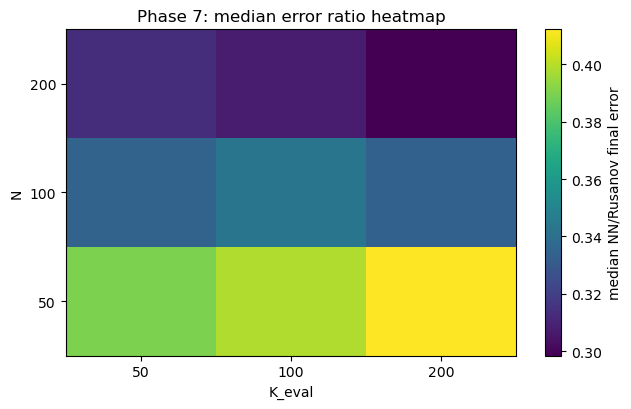

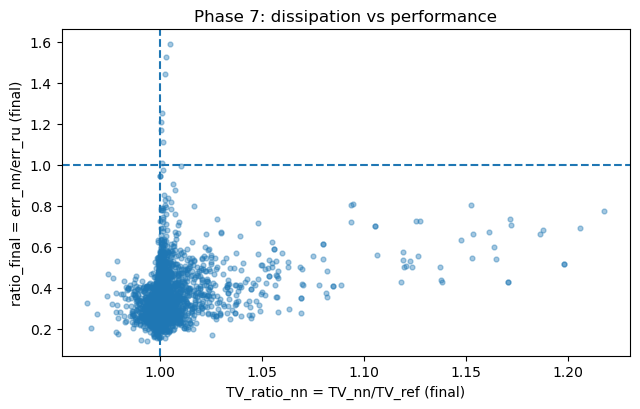


Worst 5 cases by ratio_final:


,mu_tag,N,K_eval,mu,case,n0,rep,ratio_final,err_nn_final,err_ru_final,entropy_violations_nn,TV_ratio_nn,mass_drift_nn
879,ood_high,50,200,0.091972,case_00183,498,1,1.587901,0.004925,0.003101,0,1.004900,5.716328e-08
878,ood_high,50,200,0.091972,case_00183,626,0,1.526019,0.003738,0.002450,0,1.003090,5.478147e-08
877,ood_high,50,100,0.091972,case_00183,612,1,1.440524,0.002380,0.001652,0,1.002360,1.012266e-08
876,ood_high,50,100,0.091972,case_00183,928,0,1.250425,0.001344,0.001075,0,1.001151,-1.607717e-08
875,ood_high,50,50,0.091972,case_00183,899,1,1.206642,0.000751,0.000622,0,1.000679,-4.763606e-09


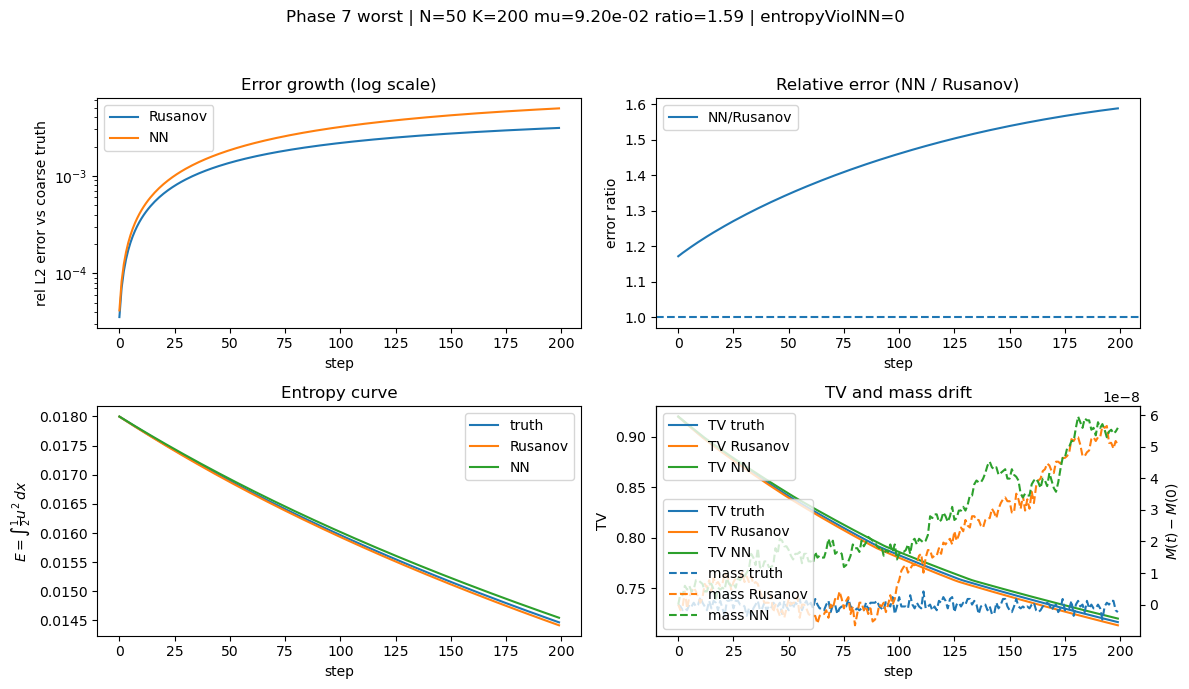

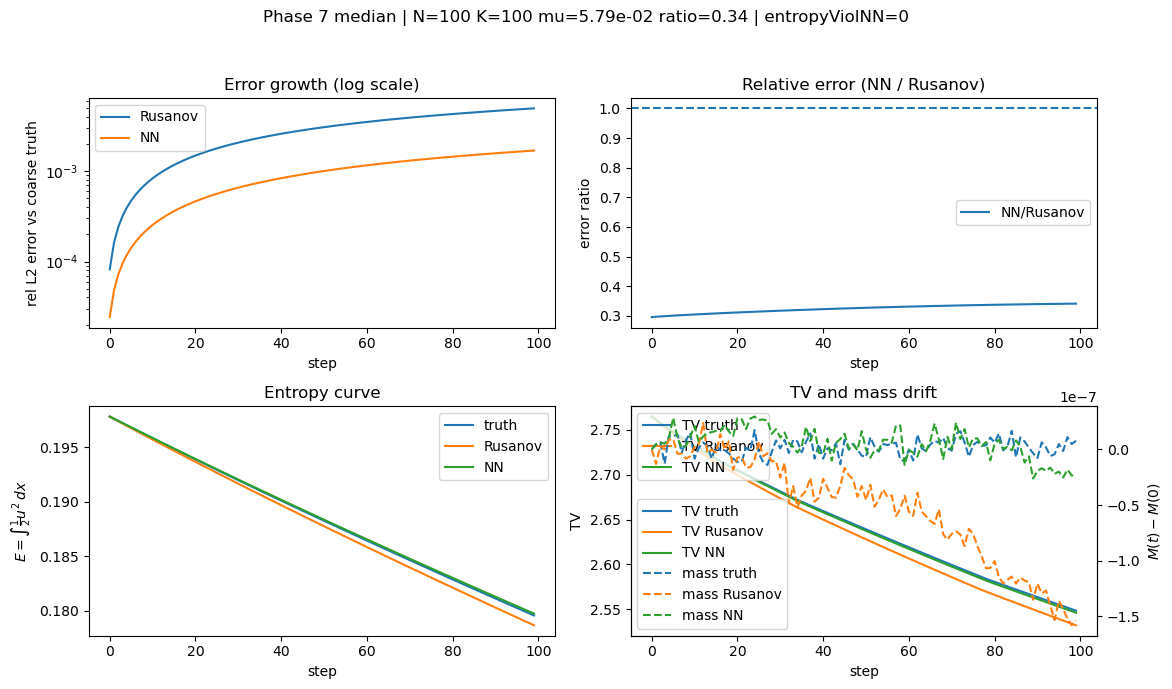

In [70]:
phase7_report_v2(df_trainIC7, curves_trainIC7, title="Phase 7", save_tag="results_phase7")

In [ ]:

# ---------------------------------------------------------------------
# Make sure imports resolve (run from repo root; adjust if needed)
# ---------------------------------------------------------------------
# If this script is in a notebook, set PROJECT_ROOT accordingly:

from src.simulate import simulate_steps
from src.fv1d import stable_timestep
from src.reference_solver import solve_reference_weno
from src.neural_flux import NeuralFlux  # needed for custom model load


# ---------------------------------------------------------------------
# 1) User choices
# ---------------------------------------------------------------------
L = 1.0
N_coarse = 128
N_fine   = 4096  # must be a multiple of N_coarse for simple averaging projection
assert (N_fine % N_coarse) == 0, "Choose N_fine as an integer multiple of N_coarse."

mu = 1e-2
T  = 0.5
cfl = 0.25

# Choose a conservative fine dt:
dt_fine = 0.10 * (L / N_fine)  # safe default for Burgers advection; reduce if needed
save_every = 1  # keep last snapshot (or set >1 to save fewer)

MODEL_PATH = "models/FirstIterate.keras"


# ---------------------------------------------------------------------
# 2) Grid + initial condition
# ---------------------------------------------------------------------
def make_grid(N: int, L: float = 1.0):
    dx = L / N
    # cell centers on [0, L)
    x = (np.arange(N) + 0.5) * dx
    return x, dx

def ic(x):
    # Example IC: smooth + localized bump (edit freely)
    return np.sin(2*np.pi*x)

# Grids
xC, dxC = make_grid(N_coarse, L)
xF, dxF = make_grid(N_fine,   L)

u0C = ic(xC).astype(np.float64)
u0F = ic(xF).astype(np.float64)


# ---------------------------------------------------------------------
# 3) Load NN flux model (custom class)
# ---------------------------------------------------------------------
nn_model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={"NeuralFlux": NeuralFlux},
    compile=False,
    safe_mode=False
)


# ---------------------------------------------------------------------
# 4) Run fine reference (WENO5) and project to coarse by cell averaging
# ---------------------------------------------------------------------
t_ref, snaps_ref_fine = solve_reference_weno(
    u0=u0F,
    x=xF,
    T=T,
    mu=mu,
    cfl=cfl, 
    save_every=save_every
)

uT_ref_fine = snaps_ref_fine[-1]  # final fine snapshot

# Project fine -> coarse by block averaging (since N_fine is multiple of N_coarse)
ratio = N_fine // N_coarse
uT_ref_coarse = uT_ref_fine.reshape(N_coarse, ratio).mean(axis=1)


# ---------------------------------------------------------------------
# 5) Run coarse FV (Rusanov) and NN-FVM on the same coarse grid
# ---------------------------------------------------------------------
# Choose a stable dt for coarse simulation (or override)
dt_coarse = stable_timestep(u0C, dxC, mu, cfl=cfl)
nsteps = int(np.ceil(T / dt_coarse))
dt_coarse = T / nsteps  # adjust so nsteps*dt_coarse == T exactly

# Baseline (Rusanov)
t_rus, snaps_rus = simulate_steps(
    u0=u0C,
    x=xC,
    mu=mu,
    nsteps=nsteps,
    model=None,         # None => Rusanov flux (per src/simulate.py)
    dt=dt_coarse,
    cfl=cfl,
    bc="periodic",
    save_every=nsteps   # save only final (or set e.g. 10 to store trajectory)
)
uT_rus = snaps_rus[-1]

# NN-FVM
t_nn, snaps_nn = simulate_steps(
    u0=u0C,
    x=xC,
    mu=mu,
    nsteps=nsteps,
    model=nn_model,     # NN flux
    dt=dt_coarse,
    cfl=cfl,
    bc="periodic",
    save_every=nsteps
)
uT_nn = snaps_nn[-1]

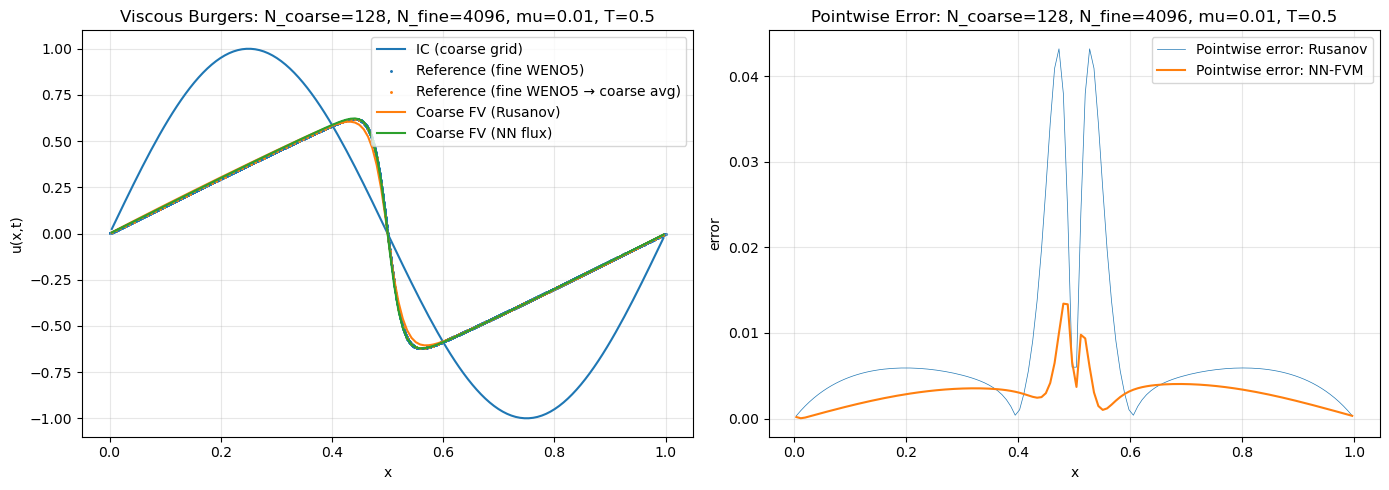

In [31]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
axs[0].plot(xC, u0C, label="IC (coarse grid)")
axs[ 0].scatter(xF, uT_ref_fine, label="Reference (fine WENO5)", s= 1.2)
axs[ 0].scatter(xC, uT_ref_coarse, label="Reference (fine WENO5 → coarse avg)", s = 1.2)
axs[ 0].plot(xC, uT_rus, label="Coarse FV (Rusanov)")
axs[ 0].plot(xC, uT_nn, label="Coarse FV (NN flux)")


axs[ 0].set_xlabel("x")
axs[ 0].set_ylabel("u(x,t)")
axs[ 0].set_title(f"Viscous Burgers: N_coarse={N_coarse}, N_fine={N_fine}, mu={mu:g}, T={T:g}")
axs[ 0].grid(True, alpha=0.3)
axs[ 0].legend()

axs[ 1].plot(xC, np.abs(uT_ref_coarse - uT_rus), label="Pointwise error: Rusanov", linewidth=0.5)
axs[ 1].plot(xC, np.abs(uT_ref_coarse - uT_nn), label="Pointwise error: NN-FVM")


axs[ 1].set_xlabel("x")
axs[ 1].set_ylabel("error")
axs[ 1].set_title(f"Pointwise Error: N_coarse={N_coarse}, N_fine={N_fine}, mu={mu:g}, T={T:g}")
axs[ 1].grid(True, alpha=0.3)
axs[ 1].legend()

plt.tight_layout()
plt.savefig('figures/Qualitative.png')
plt.show()

